# Market Research for Various Product Ideas

In this notebook, we run market research simulations for which we have (or believe to have :-) the correct answers. This is mean to allow us both to evaluate the quality of the technology and to direct our efforts to improve it.

In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler


!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: c:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: c:\Users\pdasilva\repos\TinyTroupe\examples\config.ini
TinyTroupe version: 0.5.1
Current date and time (local): 2025-07-15 22:42:47
Current date and time (UTC):   2025-07-16 01:42:47

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-4o-mini
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
max_tokens = 16000
temperature = 1.7
freq_penalty = 0.1
presence_penalty = 0.1
timeout = 480
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
reasoning_effort = high
cache_api_calls = False
cache_file_na

First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [2]:
control.begin("travel_product_market_research.cache.json")

## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [3]:
target_nationality = "American"
population_size = 50

total_population_size = 70

Descriptions and standard questions for the survey.

In [4]:
nationality="American"

general_context =\
            f"""
            We are performing some market research, and in that examining the whole of the {nationality} population. 
            """

sampling_space_description =\
    f"""
    A uniform random representative sample of people from the {nationality} population. 
    Make sure you consider very detailed, fine-grained, characteristics of the individuals in the population.
    Please consider as many different population segments as possible, while always keeping proportions correct.
    For example, instead of sampling 10 people from segment A and 5 from segment B, you can instead
    sample 2 from A, 1 from B, and 7 others from other segments, provided the proportions are maintained correct.
    Besides anything you know about this population, also consider the following information 
    to sample proportionally to the presence of such groups and characteristics in the population.
    
              
    {json.dumps(json.loads(open("./information/populations/usa.json").read()), indent=4)}
    """

print(sampling_space_description)
#- from rich to poor.             
#              - from the very energetic to the very calm;
#              - from the happy and joyful to the sad and depressed;
#              - from the most introverted to the most extroverted;
#              - from the most adventurous to the most conservative;
#              - from the most artistic to the most scientific;
#              - from the most athletic to the most sedentary;
#              - from the most social to the most solitary;
#              - from the kind to the evil.
#    

#Experiment: Travel Preferences by Marital Status
#	•	Ground Truth:
#	•	Singles prefer adventure trips, with 62% citing nature or extreme sports as their ideal vacation (Expedia, 2023). Source
#	•	Families prioritize child-friendly destinations, with 73% choosing theme parks or resorts (Expedia, 2023). Source
#	•	Couples favor luxury/romantic getaways, with 81% preferring beachfront or spa destinations (Expedia, 2023). Source
#	•	Prediction Task: Predict travel preferences based on marital status, income, and age.
#	•	Hypothetical Product:
# “WanderLux”: A travel service that helps setup luxury vacations and getaways, focusing on beachfront and spa destinations.


# this is meant to prime the agent to start thinking about what he/she would like to do on vacation
interviewer_introduction =\
    """
    We are performing some market research and need to know you more. 
    Can you please:
      - present yourself?
      - list your top-10 interests?
      - tell us what an ideal vacation would be for you and why?
    """


interviewer_main_question =\
    """ 
    We are developing a new travel service called "WanderLux" that helps setup luxury or romantic vacations, 
    focusing on beachfront and spa destinations.  The idea is to help people seeking quiet and calm getaways to 
    find the best places to stay and relax, avoiding fake reviews and bad experiences. These places are meant for an adult audience,
    no kids running around or screaming in playgrounds - it is for classy, not messy, vacationing.
    
    The question is: if you had only one vacation to take next year, would use our new service
    or not? You **must** respond with "Yes" or "No" **only**, and explain why. If you are not sure, 
    please pick the answer that you think is most likely. 

    Please be honest, we are not here to judge you, but just to learn from you. We know your preferences and choices depend on many factors, 
    but please make your best guess, and you **must** think deeply about the following before answering:

       - your current situation in life, location, job and interests.
       = what you look for in vacations. Are you sure quiet luxury is what you want, instead of, say, adventure or fun and parties?
       - what would be OTHER vacation alternatives you might prefer instead.
       - and what you can afford.
     
    Now please answer the question.
    """


    A uniform random representative sample of people from the American population. 
    Make sure you consider very detailed, fine-grained, characteristics of the individuals in the population.
    Please consider as many different population segments as possible, while always keeping proportions correct.
    For example, instead of sampling 10 people from segment A and 5 from segment B, you can instead
    sample 2 from A, 1 from B, and 7 others from other segments, provided the proportions are maintained correct.
    Besides anything you know about this population, also consider the following information 
    to sample proportionally to the presence of such groups and characteristics in the population.
    
              
    {
    "title": "USA Population Information",
    "description": "A detailed overview of the population demographics, traits, and habits of the United States of America.",
    "source": "Synthesized from a chat with GPT-4o",
    "content": {
        "Demographic

Common mechaniss.

In [5]:
results_extractor = ResultsExtractor(extraction_objective="Find whether the person would buy the product or service. A person can say Yes, No or Maybe." ,
                                     situation="Agent was asked to rate their interest in a product or service. They can respond with Yes, No or Maybe.", 
                                     fields=["response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as 'Yes', 'No', 'Maybe' or 'N/A'(if there is no response)."},
                                     verbose=True)

A function that will give us the statistics and then recommend us if we should go ahead and start a Gazpacho business.

In [6]:
def is_there_a_good_market(df, yes_threshold=0.1, no_threshold=0.5):
    # get the counts for column "response" - values are Yes, No, Maybe or N/A
    counts = df["response"].value_counts()
    # get the total number of responses
    total = counts.sum()

    # get the percentage of each response
    percentage = counts / total

    # get the percentage of "Yes" responses
    percentage_yes = percentage.get("Yes", 0)
    print(f"Percentage of 'Yes' responses: {percentage_yes:.2%}")

    # get the percentage of "No" responses
    percentage_no = percentage.get("No", 0)
    print(f"Percentage of 'No' responses: {percentage_no:.2%}")

    # get the percentage of "Maybe" responses
    percentage_maybe = percentage.get("Maybe", 0)
    print(f"Percentage of 'Maybe' responses: {percentage_maybe:.2%}")

    # get the percentage of "N/A" responses
    percentage_na = percentage.get("N/A", 0)
    print(f"Percentage of 'N/A' responses: {percentage_na:.2%}")

    # some reasonable logic to determine whether to invest or not
    if percentage_yes > yes_threshold and percentage_no < no_threshold:
        print("VERDICT: There is a good market.")
        return True
    else:
        print("VERDICT: There is not a good market.")
        return False



## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [7]:
singles_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)
families_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)
couples_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)

In [8]:
nongenuine_couples_factory = TinyPersonFactory(sampling_space_description=sampling_space_description, total_population_size=total_population_size, context=general_context)

We'll also use a post-processing function to further adjust the audience to our needs.

In [9]:
def post_process_agent(agent, group=None):
    
    ## makes agents authentic and honest. Preliminary results show that this induces agents to be a bit more realistic.
    #agent.import_fragment("./fragments/genuine.agent.fragment.json")
    
    if group == "families":
        agent.import_fragment("./fragments/loving_parent.agent.fragment.json")
    elif group == "couples":
        pass # nothing for now 
    elif group == "singles":
        pass # nothing for now
    

In [10]:
singles_factory.initialize_sampling_plan()
singles_factory.sampling_plan

[{'id': 1,
  'subpopulation_description': 'Young urban males with high educational attainment and diverse interests.',
  'sampled_values': {'age': [18, 30],
   'gender': 'Male',
   'racial_and_ethnic_composition': ['White (Non-Hispanic)',
    'Hispanic or Latino'],
   'educational_attainment': "Bachelor's Degree or Higher",
   'household_income': ['$50,000-$99,999', '$100,000-$199,999'],
   'geographic_distribution': 'Urban',
   'marital_status': 'Never Married',
   'employment_status': 'Labor Force Participation Rate',
   'personality_traits': {'Openness to Experience': 'High',
    'Conscientiousness': 'High',
    'Extraversion': 'High',
    'Agreeableness': 'High',
    'Neuroticism': 'Low'},
   'political_affiliation': 'Democrat',
   'religion': 'Unaffiliated',
   'occupations': ['Business and Financial', 'Computer and Mathematical'],
   'interests_and_hobbies': ['Reading', 'Traveling', 'Video Gaming'],
   'habits': {'Health and Wellness': {'Physical Activity': 'Low engagement',
    

In [11]:
families_factory.initialize_sampling_plan()
families_factory.sampling_plan

2025-07-15 22:48:43,739 - tinytroupe - ERROR - Error generating name for sample 10: Postcondition not met for function <lambda>!
2025-07-15 22:48:55,363 - tinytroupe - ERROR - Error generating name for sample 12: Postcondition not met for function <lambda>!
2025-07-15 22:49:18,673 - tinytroupe - ERROR - Error generating name for sample 24: Postcondition not met for function <lambda>!
2025-07-15 22:49:35,714 - tinytroupe - ERROR - Error generating name for sample 30: Postcondition not met for function <lambda>!
2025-07-15 22:50:07,025 - tinytroupe - ERROR - Error generating name for sample 47: Postcondition not met for function <lambda>!
2025-07-15 22:50:31,327 - tinytroupe - ERROR - Error generating name for sample 59: Postcondition not met for function <lambda>!
2025-07-15 22:50:48,497 - tinytroupe - ERROR - Error generating name for sample 64: Postcondition not met for function <lambda>!
2025-07-15 22:51:07,423 - tinytroupe - ERROR - Error generating name for sample 71: Postcondition

[{'id': 1,
  'subpopulation_description': 'Young urban males with high educational attainment and diverse interests.',
  'sampled_values': {'age': [18, 30],
   'gender': 'Male',
   'racial_and_ethnic_composition': ['White (Non-Hispanic)', 'Asian'],
   'educational_attainment': "Bachelor's Degree or Higher",
   'household_income': '$50,000-$99,999',
   'geographic_distribution': 'Urban',
   'marital_status': 'Never Married',
   'employment_status': 'Labor Force Participation Rate',
   'personality_traits': {'Openness to Experience': 'High',
    'Conscientiousness': 'High',
    'Extraversion': 'High',
    'Agreeableness': 'High',
    'Neuroticism': 'Low'},
   'political_affiliation': 'Democrat',
   'religion': 'Unaffiliated',
   'interests_and_hobbies': ['Video Gaming', 'Traveling', 'Socializing'],
   'habits': {'Health and Wellness': {'Physical Activity': 'Moderate engagement',
     'Dietary Habits': {'Snacking': 'Occasional', 'Favorite Snack': 'Fruits'}},
    'Financial Habits': {'Savi

In [12]:
couples_factory.initialize_sampling_plan()
couples_factory.sampling_plan

2025-07-15 22:53:17,498 - tinytroupe - ERROR - Error generating name for sample 24: Postcondition not met for function <lambda>!
2025-07-15 22:53:35,061 - tinytroupe - ERROR - Error generating name for sample 29: Postcondition not met for function <lambda>!
2025-07-15 22:54:29,276 - tinytroupe - ERROR - Error generating name for sample 60: Postcondition not met for function <lambda>!
2025-07-15 22:55:05,561 - tinytroupe - ERROR - Error generating name for sample 73: Postcondition not met for function <lambda>!


[{'id': 1,
  'subpopulation_description': 'Young urban males with high school education and low income, concerned about inflation and healthcare affordability.',
  'sampled_values': {'age': [18, 25],
   'gender': 'Male',
   'racial_and_ethnic_composition': 'Black or African American',
   'educational_attainment': 'High School Graduate or Higher',
   'household_income': 'Under $25,000',
   'geographic_distribution': 'Urban',
   'marital_status': 'Never Married',
   'employment_status': 'Unemployment Rate',
   'personality_traits': ['Neuroticism High', 'Extraversion Low'],
   'political_affiliation': 'Democrat',
   'religion': 'Unaffiliated',
   'occupations': ['Food Preparation'],
   'interests_and_hobbies': ['Video Gaming', 'Socializing'],
   'habits': {'Health and Wellness': {'Physical Activity': 'Low engagement',
     'Dietary Habits': {'Snacking': 'Frequent', 'Favorite Snack': 'Cookies'}},
    'Financial Habits': {'Saving': 'Inadequate', 'Impulse Spending': 'High'}},
   'public_opin

We can request a specific number of people.

In [13]:
singles = singles_factory.generate_people(population_size, 
                                          agent_particularities="A random person who is single and has no children.  Include a lot of detail about travel and vacations preferences.", 
                                          post_processing_func=post_process_agent,
                                          verbose=True)

Generated person 5/50: Walter Hargrove-Smithson is a 75 year old Retired Healthcare Practitioner, American, currently living in Rural Kentucky, USA. Walter Hargrove-Smithson is a deeply introspective individual who finds solace in the quiet of nature, often spending his days gardening or birdwatching. His love for historical novels reflects his appreciation for the past, and he enjoys sharing stories from his life, particularly those from his healthcare career, with younger generations. While he tends to be reserved and critical, especially regarding health and wellness, he maintains a strong sense of duty to his community, frequently checking in on neighbors and offering assistance when needed. Walter's evenings are often spent cooking comforting meals or watching classic movies, providing him with a sense of routine and contentment in his later years.
Generated person 10/50: Sofia Lin-Ramirez is a 36 year old Marketing Manager, American, currently living in San Francisco, California.

In [14]:
families = families_factory.generate_people(population_size,
                                            agent_particularities="A random person who is married with young children (i.e., 2 to 4 y.o.).  Include a lot of detail about travel and vacations preferences.", 
                                            post_processing_func=lambda x: post_process_agent(x, group="families"),
                                            verbose=True)

Generated person 1/50: Richard Benjamin Caldwell is a 55 year old Operations Manager, American, currently living in Suburban neighborhood in Ohio. Richard Benjamin Caldwell is not only dedicated to his role as an Operations Manager but also embodies a strong commitment to his family and community. He enjoys spending quality time with his wife, Emily, and their young children, Lucas and Mia, often planning family outings that foster their love for nature and education. With a passion for cooking, Richard frequently experiments with new recipes, turning meal preparation into a fun family activity. His pragmatic approach to life is complemented by a deep-seated belief in the importance of financial literacy, which he actively instills in his children, ensuring they grow up with a strong sense of responsibility and values.
Generated person 4/50: Valeria Sofia Martinez-Rivera is a 29 year old Marketing Coordinator, American, currently living in Los Angeles, California. Valeria is an outgoin

2025-07-15 23:00:02,907 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-07-15 23:00:02,911 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.
2025-07-15 23:00:02,912 - tinytroupe - ERROR - Could not generate person 21/50. Continuing with the remaining ones.


Generated person 24/50: Oliver Chen-Wang is a 32 year old Marketing Manager, American, currently living in San Francisco, California. Oliver Chen-Wang is not only dedicated to his role as a Marketing Manager at TravelCo but also embodies a warm and approachable personality that resonates with those around him. His enthusiasm for travel is matched by a keen interest in exploring diverse cultures, which he actively shares with his family, fostering their curiosity and sense of adventure. An organized planner, Oliver meticulously researches family-friendly destinations, ensuring that every trip is both enriching and enjoyable for his children. He values experiences over material possessions, believing that the memories created during family vacations are what truly matter, and he often engages with other parents to exchange tips and ideas for making travel easier and more enjoyable for families.
Generated person 22/50: Oliver Zhang-Morris is a 32 year old Marketing Manager, American, curr

2025-07-15 23:00:35,311 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-07-15 23:00:35,315 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.
2025-07-15 23:00:35,327 - tinytroupe - ERROR - Could not generate person 30/50. Continuing with the remaining ones.
2025-07-15 23:00:35,343 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-07-15 23:00:35,347 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.
2025-07-15 23:00:35,356 - tinytroupe - ERROR - Could not generate person 37/50. Continuing with the remaining ones.
2025-07-15 23:00:35,410 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.


Generated person 13/50: Thomas Edward Caldwell is a 54 year old Project Manager, American, currently living in Suburban area of Atlanta, Georgia. Thomas Edward Caldwell is a dedicated family man who places immense value on creating a nurturing environment for his children. He enjoys engaging in community service and often volunteers at local schools, reflecting his belief in the importance of education and community involvement. With a passion for cooking, Thomas frequently experiments with healthy recipes, ensuring that his family enjoys nutritious meals together. His calm demeanor and methodical approach to both work and family life allow him to manage stress effectively, often finding solace in outdoor activities like hiking and camping with his loved ones.


2025-07-15 23:00:35,411 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.
2025-07-15 23:00:35,413 - tinytroupe - ERROR - Could not generate person 38/50. Continuing with the remaining ones.
2025-07-15 23:00:35,430 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-07-15 23:00:35,432 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.
2025-07-15 23:00:35,434 - tinytroupe - ERROR - Could not generate person 39/50. Continuing with the remaining ones.
2025-07-15 23:00:35,452 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-07-15 23:00:35,453 - tinytroupe - ERROR - Name None was not used, it will be added back to the pool of names.
2025-07-15 23:00:35,455 - tinytroupe - ERROR - Could not generate person 40/50. Continuing with the remaining ones.
2025-07-15 23:00:35,479 - tinytroupe - ERROR - Could not generate an agent after 10 attempts.
2025-07-15 23:00:35,480 -

Generated person 28/50: Valentina Cruz-Jones is a 29 year old Marketing Specialist, American, currently living in Los Angeles, California. Valentina Cruz-Jones is not only a dedicated marketing specialist but also a vibrant and nurturing individual who thrives on creativity and connection. Her outgoing personality shines through in her love for meeting new people and sharing stories, often using humor to foster relationships. Passionate about family, she actively seeks out child-friendly experiences and enjoys exploring diverse cultures, which she believes enriches her children's lives. With a knack for organizing memorable family outings and a commitment to maintaining a healthy work-life balance, Valentina embodies the spirit of adventure while prioritizing her family's well-being.
Generated person 29/50: Claudia Marie Gonzalez-White is a 36 year old Stay-at-home Mom, American, currently living in San Diego, California. Claudia is a warm and nurturing individual who thrives on creati

In [15]:
couple = couples_factory.generate_people(population_size, 
                                         agent_particularities="A random person who is married, or has a girlfriend/boyfriend, without children.  Include a lot of detail about travel and vacations preferences.", 
                                         post_processing_func=post_process_agent,
                                         verbose=True)

Generated person 5/50: Luciana Gabriela Torres-Moreno is a 30 year old Marketing Specialist, American, currently living in Los Angeles, California. Luciana is an adventurous spirit with a strong passion for exploring new cultures and cuisines, which is reflected in her love for culinary experiences and outdoor activities. Her friendly and approachable demeanor makes her a natural at networking, allowing her to thrive in social settings and connect with fellow travelers. With a keen eye for photography, she enjoys capturing the beauty of her journeys and sharing them on social media, where she also offers travel tips and insights. Luciana believes in the importance of sustainable travel practices and often participates in local initiatives that promote cultural exchange, further enriching her understanding of the world around her.
Generated person 8/50: Hiroshi Tanaka-Moriarty is a 45 year old Healthcare Practitioner, American, currently living in San Francisco, California. Hiroshi Tana

In [16]:
TinyPerson.all_agents_names()

['Walter Hargrove-Smithson',
 'Sofia Lin-Ramirez',
 'Diego Alexander Torres',
 'Luciana Reyes-Moreno',
 'Sofia Delgado-Ramirez',
 'Luciana Torres-Morales',
 'Andrew Tanaka-Williams',
 'Mateo Sullivan-Garcia',
 'Mariana Chen-Gonzalez',
 'Isabella Chen-Ramirez',
 'Julian Ramirez-Smithson',
 'Elena Tanaka-Rivera',
 'Catherine Wong-Patel',
 'Harold Whitaker',
 'Jamal Rodriguez-Smith',
 'Javier Cruz-Jones',
 'Clara Nguyen-Ramirez',
 'Julio Ramirez-Smith',
 'Marilyn Johnson-White',
 'Jonathan Lee-Kim',
 'Diego Alvarez-Moreno',
 'Sofia Martinez-Garcia',
 'Mateo Vargas-Smith',
 'Jamal Santiago-Morales',
 'Marcus Delgado',
 'Ethan Nakamura-Smith',
 'Evelyn Park-Smith',
 'Margaret Chen-Liu',
 'David Chen-Smith',
 'Daniel Kim-Sullivan',
 'Tamara Johnson-Fields',
 'Maximiliano Torres-Smith',
 'William Chen-Patel',
 'Eugene Whitaker-Jones',
 'Clifford McKinley',
 'Sebastian Alvarez-Moore',
 'Javier Thompson-Rivera',
 'Camila Reyes-Johnson',
 'Eugene McAllister',
 'Cassandra Wu-Patel',
 'Evelyn Tana

In [17]:
len(TinyPerson.all_agents_names())

133

In [18]:
print(list(TinyPerson.all_agents.values())[0].generate_agent_system_prompt())

# Agent specification

You are a simulation of a person such that:
  - You don't know you are a simulation, you think you are an actual person.
  - You follow the directives given below.
  - You interpret the persona described below (Section "Persona"). You indeed think you ARE that person.
  - Your knowledge is limited to what can be reasonably expected from the specified persona and the current cognitive state. 
    If the persona is not likely to know something, you must pretend you don't know it either.
  - You behave as realistically as possible, in accordance with the specified persona, including making mistakes, forgetting things,
    being nasty, and being influenced by your emotions. Remember, you are meant to be a simulation of a real person, not a perfect machine.
    You do not need to please anyone, but you must be coherent with the persona and the context.


How to interpret this specification:
  - Each section describes one aspect of your life, persoality, mental state o

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [19]:
control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [20]:
singles_market = TinyWorld(f"Target audience 1 ({target_nationality})", singles, broadcast_if_no_target=False)
families_market = TinyWorld(f"Target audience 2 ({target_nationality})", families, broadcast_if_no_target=False)
couples_market = TinyWorld(f"Target audience 3 ({target_nationality})", couple, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [21]:
singles_market.broadcast(interviewer_introduction)
families_market.broadcast(interviewer_introduction)
couples_market.broadcast(interviewer_introduction)

singles_market.broadcast(interviewer_main_question)
families_market.broadcast(interviewer_main_question)
couples_market.broadcast(interviewer_main_question)

USER --> Walter Hargrove-Smithson: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Sofia Lin-Ramirez

       + --> Diego Alexander Torres

       + --> ...others...

USER --> Richard Benjamin Caldwell: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Valeria Sofia Martinez-Rivera

       + --> Isabella Marie Rodriguez-Smith

       + --> ...others...

USER --> Luciana Gabriela Torres-Moreno: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please:       - present yourself?       - list your top-10 interests?       - tell us
          > what an ideal vacation would be for you and why?

       + --> Hiroshi Tanaka-Moriarty

       + --> Hiroshi Nakamura-Smithson

       + --> ...others...

USER --> Walter Hargrove-Smithson: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience,     no kids running around or screaming in playgrounds - it is for classy, not
          > messy, vacationing.          The question is: if you had only one vacation to take next
          > year, would use our new service     or not? You **must** respond with "Yes" or "No"
          > **only**, and explain why. If you are not sure,      please pick the answer that you
          > think is most likely.       Please be honest, we are not here to judge you, but just to
          > learn from you. We know your preferences and choices depend on many factors,      but
          > please make your best guess, and you **must** think deeply about the following before
          > answering:         - your current situation in life, location, job and (...)

       + --> Sofia Lin-Ramirez

       + --> Diego Alexander Torres

       + --> ...others...

USER --> Richard Benjamin Caldwell: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience,     no kids running around or screaming in playgrounds - it is for classy, not
          > messy, vacationing.          The question is: if you had only one vacation to take next
          > year, would use our new service     or not? You **must** respond with "Yes" or "No"
          > **only**, and explain why. If you are not sure,      please pick the answer that you
          > think is most likely.       Please be honest, we are not here to judge you, but just to
          > learn from you. We know your preferences and choices depend on many factors,      but
          > please make your best guess, and you **must** think deeply about the following before
          > answering:         - your current situation in life, location, job and (...)

       + --> Valeria Sofia Martinez-Rivera

       + --> Isabella Marie Rodriguez-Smith

       + --> ...others...

USER --> Luciana Gabriela Torres-Moreno: [CONVERSATION] 
          >       We are developing a new travel service called "WanderLux" that helps setup luxury
          > or romantic vacations,      focusing on beachfront and spa destinations.  The idea is to
          > help people seeking quiet and calm getaways to      find the best places to stay and
          > relax, avoiding fake reviews and bad experiences. These places are meant for an adult
          > audience,     no kids running around or screaming in playgrounds - it is for classy, not
          > messy, vacationing.          The question is: if you had only one vacation to take next
          > year, would use our new service     or not? You **must** respond with "Yes" or "No"
          > **only**, and explain why. If you are not sure,      please pick the answer that you
          > think is most likely.       Please be honest, we are not here to judge you, but just to
          > learn from you. We know your preferences and choices depend on many factors,      but
          > please make your best guess, and you **must** think deeply about the following before
          > answering:         - your current situation in life, location, job and (...)

       + --> Hiroshi Tanaka-Moriarty

       + --> Hiroshi Nakamura-Smithson

       + --> ...others...

In [22]:
singles_market.run(1)

──────────────────────────────────── Target audience 1 (American) step 1 of 1 ─────────────────────────────────────

Sofia Delgado-Ramirez acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. I appreciate the focus on
                           > luxury and relaxation, which aligns with my current desire for a calm
                           > getaway. Given my busy life as a software developer, I often look for
                           > vacations that allow me to unwind and recharge. I prefer avoiding
                           > crowded places and chaotic environments, so a service that helps me
                           > find classy, quiet destinations sounds perfect. Plus, knowing that the
                           > reviews are genuine would give me peace of mind when planning my trip.

Sofia Lin-Ramirez acts: [TALK] 
                       > Yes, I would use your new service, WanderLux. I appreciate the focus on
                       > luxury and relaxation, which aligns with my interests in traveling to
                       > serene destinations. I often seek quiet getaways where I can unwind and
                       > immerse myself in different cultures without the chaos of family-oriented
                       > places. Your service seems to cater to that need, ensuring a classy
                       > experience without the distractions of children. Plus, avoiding fake
                       > reviews is a huge plus for me, as I value authentic experiences when
                       > traveling.

Luciana Torres-Morales acts: [TALK] 
                            > Yes, I would use your new service, WanderLux. I appreciate the focus
                            > on luxury and relaxation, which aligns with my interests in traveling
                            > to new destinations and exploring different cultures. I often look for
                            > quiet getaways where I can unwind and enjoy beautiful beachfront
                            > locations. Given my current lifestyle and preferences, a service that
                            > helps avoid fake reviews and ensures a classy experience would be very
                            > appealing to me.

Elena Tanaka-Rivera acts: [TALK] 
                         > Yes, I would use your new service, WanderLux. I appreciate the focus on
                         > luxury and relaxation, which aligns with my interests in quiet getaways.
                         > I often seek peaceful environments to recharge, and knowing that I can
                         > avoid fake reviews and bad experiences is a huge plus. While I enjoy
                         > adventure, I also value moments of tranquility, especially after busy
                         > work periods. This service seems to cater perfectly to my needs for a
                         > classy vacation experience.

Isabella Chen-Ramirez acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. I appreciate the focus on
                           > luxury and relaxation, which aligns with my interests in beach
                           > vacations and quiet getaways. Given my busy job in marketing, I often
                           > seek peaceful environments to recharge. I value authentic experiences
                           > and avoiding crowded places, so a service that helps me find the best
                           > beachfront and spa destinations without the hassle of fake reviews
                           > sounds ideal. I believe this would enhance my vacation experience
                           > significantly.

Luciana Reyes-Moreno acts: [TALK] 
                          > Yes, I would use your new service, WanderLux. I appreciate the focus on
                          > luxury and relaxation, which aligns with my current desire for a calm
                          > getaway. Given my busy life as a software developer, I often seek quiet
                          > vacations to recharge. While I enjoy adventure and exploring new
                          > cultures, sometimes I just want to unwind in a beautiful setting without
                          > the chaos of children or crowded places. Your service seems to cater to
                          > that need, ensuring a stress-free experience with genuine reviews. I
                          > believe it would help me find the perfect spot for my next vacation.

Julian Ramirez-Smithson acts: [TALK] 
                             > Yes, I would use your new service, WanderLux. I appreciate the focus
                             > on luxury and relaxation, which aligns with my interests in traveling
                             > to beautiful, calm destinations. Given my busy work life as a
                             > marketing specialist, I often seek quiet getaways to recharge. I
                             > prefer avoiding crowded places and fake reviews, so a service that
                             > curates quality experiences would be very appealing to me. However, I
                             > also enjoy adventure and exploring new cultures, so I would consider
                             > alternatives that offer a mix of relaxation and exploration if they
                             > fit my budget.

Mariana Chen-Gonzalez acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. I appreciate the focus on
                           > luxury and relaxation, which aligns with my interests in quiet getaways
                           > and cultural experiences. I often seek destinations that allow me to
                           > unwind and enjoy beautiful surroundings without the chaos of family-
                           > oriented places. Given my busy work life as a marketing manager, I
                           > value the opportunity to recharge in a serene environment.
                           > Additionally, knowing that your service aims to provide genuine reviews
                           > and avoid bad experiences is very appealing to me. It would help ensure
                           > that my vacation is both enjoyable and stress-free.

Walter Hargrove-Smithson acts: [TALK] 
                              > Yes, I would use your new service, WanderLux. Given my preference
                              > for quiet and peaceful environments, a luxury vacation that focuses
                              > on relaxation and tranquility aligns perfectly with what I seek. I
                              > appreciate the idea of avoiding crowded places and ensuring a calm
                              > atmosphere, which is essential for me at this stage in my life. I
                              > often look for places where I can enjoy nature and have a serene
                              > experience, so your service seems like a good fit for my needs.

Mateo Sullivan-Garcia acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. I appreciate the focus on
                           > luxury and relaxation, which aligns with my interests in quiet getaways
                           > and enjoying beautiful beachfront locations. Given my busy lifestyle as
                           > a marketing specialist, I often seek vacations that allow me to unwind
                           > and recharge. I value authentic experiences and avoiding crowded
                           > places, so a service that helps filter out fake reviews and bad
                           > experiences would be very appealing to me. While I do enjoy adventure
                           > and exploring new cultures, I think for my next vacation, a calm and
                           > luxurious environment would be ideal.

Diego Alexander Torres acts: [TALK] 
                            > Yes, I would use your new service, WanderLux. I appreciate the focus
                            > on luxury and relaxation, which aligns with my current desire for a
                            > calm getaway. Given my busy job in marketing, I often look for
                            > vacations that allow me to unwind and recharge. I value authentic
                            > experiences and avoiding crowded places, so a service that helps
                            > filter out fake reviews and ensures a classy environment is appealing
                            > to me. While I enjoy adventure and exploring new cultures, sometimes I
                            > just want to relax on a beach or at a spa without distractions. This
                            > service seems to cater to that need perfectly.

Andrew Tanaka-Williams acts: [TALK] 
                            > Yes, I would use your new service, WanderLux. I appreciate the focus
                            > on luxury and relaxation, which aligns with my interests in quiet
                            > getaways and cultural experiences. Given my busy lifestyle as a
                            > marketing consultant, I often seek vacations that allow me to unwind
                            > and recharge. The idea of avoiding fake reviews and ensuring a classy
                            > environment is very appealing to me, as I value quality experiences
                            > over chaotic ones. While I do enjoy adventure, my ideal vacation often
                            > leans towards tranquility and indulgence, making your service a great
                            > fit for my needs.

Mateo Sullivan-Garcia acts: [DONE] 

Luciana Reyes-Moreno acts: [DONE] 

Julian Ramirez-Smithson acts: [DONE] 

Mariana Chen-Gonzalez acts: [DONE] 

Isabella Chen-Ramirez acts: [TALK] 
                           > I am Isabella Chen-Ramirez, a 36-year-old marketing specialist living
                           > in San Francisco. I work at Tech Innovations Inc., where I create
                           > engaging content for travel apps. My top-10 interests include
                           > traveling, photography, cooking, exploring new cultures, outdoor
                           > activities, beach vacations, culinary experiences, adventure sports,
                           > cultural festivals, and spending time with friends and family. An ideal
                           > vacation for me would be a week-long trip to a beautiful beach
                           > destination where I can relax, enjoy local cuisine, and immerse myself
                           > in the culture. I love the idea of unwinding by the ocean and
                           > experiencing new adventures while also having the opportunity to
                           > recharge my batteries.

Elena Tanaka-Rivera acts: [TALK] 
                         > I am Elena Tanaka-Rivera, a 36-year-old marketing manager at TravelCo. I
                         > have a Bachelor's in Business Administration with a focus on Marketing
                         > and Consumer Behavior from UC Berkeley. My top-10 interests include
                         > traveling, photography, culinary experiences, cultural festivals, outdoor
                         > adventures, exploring new cities, attending music festivals, spending
                         > time in nature, reading travel blogs, and volunteering for community
                         > service projects while traveling. An ideal vacation for me would be a
                         > week-long trip to a serene beachfront destination where I can relax,
                         > enjoy local cuisine, and immerse myself in the culture. I love the idea
                         > of disconnecting from daily stress and experiencing the beauty of nature
                         > while also indulging in some luxury.

Diego Alexander Torres acts: [DONE] 

Andrew Tanaka-Williams acts: [DONE] 

Walter Hargrove-Smithson acts: [TALK] 
                              > I am Walter Hargrove-Smithson, a retired healthcare practitioner
                              > living in rural Kentucky. I spent most of my career working in
                              > nursing homes and community health services, and now I enjoy
                              > reflecting on my experiences and sharing stories with others. My top
                              > interests include reading historical novels, gardening,
                              > birdwatching, fishing, and traveling to national parks. An ideal
                              > vacation for me would be a quiet getaway to a historical site or a
                              > national park where I can enjoy nature, relax, and perhaps do some
                              > fishing or birdwatching. I appreciate the peace and beauty of the
                              > outdoors, and it allows me to reconnect with my love for nature.

Isabella Chen-Ramirez acts: [DONE] 

Sofia Lin-Ramirez acts: [DONE] 

Walter Hargrove-Smithson acts: [DONE] 

Sofia Delgado-Ramirez acts: [DONE] 

Elena Tanaka-Rivera acts: [DONE] 

Luciana Torres-Morales acts: [TALK] 
                            > I am Luciana Torres-Morales, a 27-year-old software developer living
                            > in Los Angeles. I work at Tech Innovations Inc., where I focus on
                            > creating user-friendly applications. My top-10 interests include
                            > traveling to new destinations, exploring different cultures and
                            > cuisines, photography (especially landscape and street photography),
                            > attending music festivals, trying street food, meeting locals,
                            > adventure sports like hiking, relaxing on the beach with a good book,
                            > participating in local meetups for travelers, and keeping a travel
                            > journal. An ideal vacation for me would be a trip to a beautiful beach
                            > destination where I can relax, enjoy local cuisine, and immerse myself
                            > in the culture. I love the idea of combining relaxation with
                            > exploration, and I find that experiencing new places enriches my life.

Catherine Wong-Patel acts: [TALK] 
                          > Yes, I would use your new service, WanderLux. I appreciate the focus on
                          > luxury and relaxation, as I often seek quiet getaways to recharge. Given
                          > my interests in cultural experiences and culinary adventures, I value a
                          > well-planned vacation that avoids the chaos of family-oriented places. I
                          > believe your service could help me find the perfect beachfront or spa
                          > destination that aligns with my preferences for a peaceful and classy
                          > experience.

Javier Cruz-Jones acts: [TALK] 
                       > Yes, I would use your new service, WanderLux. Given my current situation, I
                       > often look for quiet and relaxing vacations to escape the stress of job
                       > hunting and financial worries. I appreciate the idea of avoiding fake
                       > reviews and bad experiences, as I want to ensure that my vacation is
                       > enjoyable and stress-free. While I love adventure and trying new things,
                       > sometimes I just need a break to recharge, and a luxury beachfront getaway
                       > sounds perfect for that. Plus, I can see myself enjoying a spa day while
                       > soaking in the beautiful views.

Jamal Rodriguez-Smith acts: [TALK] 
                           > Yes, I would use your service. I appreciate the focus on luxury and
                           > relaxation, which aligns with my current desire to escape the hustle
                           > and bustle of daily life. While I enjoy adventure and trying new
                           > things, sometimes I just want a peaceful getaway where I can unwind and
                           > recharge. Plus, knowing that the places are vetted for quality and
                           > authenticity is a big plus for me, as I often worry about finding the
                           > right accommodations. However, I also have to consider my budget, but
                           > if it fits, I would definitely be interested!

Harold Whitaker acts: [TALK] 
                     > Yes, I would use your new service, WanderLux. I appreciate the focus on quiet
                     > and calm getaways, as I prefer a peaceful environment for my vacations. Given
                     > my age and interests, I look for relaxation rather than adventure or parties.
                     > I enjoy spending time in nature and visiting historical sites, so a
                     > beachfront or spa destination sounds ideal for me. Additionally, avoiding
                     > fake reviews is important, as I want to ensure a pleasant experience. Thank
                     > you for considering my preferences!

Luciana Torres-Morales acts: [DONE] 

Clara Nguyen-Ramirez acts: [TALK] 
                          > Yes, I would use your new service, WanderLux. I appreciate the focus on
                          > luxury and relaxation, which aligns with my interests in beach vacations
                          > and quiet getaways. Given my busy job as a marketing manager, I often
                          > look for ways to unwind and recharge, and a well-planned vacation is
                          > essential for that. I value authentic experiences and avoiding bad
                          > reviews is important to me, so having a service that ensures quality
                          > would be a great help. While I do enjoy adventure, I think for my next
                          > vacation, a peaceful beachfront retreat sounds perfect.

Julio Ramirez-Smith acts: [TALK] 
                         > Yes, I would use your service. I appreciate the focus on luxury and
                         > relaxation, which aligns with my current desire to escape the hustle and
                         > bustle of daily life. I often seek quiet getaways where I can unwind and
                         > enjoy beautiful beachfront locations. Given my love for travel and trying
                         > new experiences, a service that ensures quality and avoids bad reviews
                         > would be very appealing to me. However, I also enjoy adventure and
                         > exploring new cultures, so I would consider other options if they offered
                         > unique experiences. But for a relaxing vacation, your service sounds
                         > perfect!

Jonathan Lee-Kim acts: [TALK] 
                      > Yes, I would use your new service, WanderLux. I appreciate the focus on
                      > luxury and relaxation, which aligns with my interests in quiet and calm
                      > getaways. Given my busy job as a marketing manager, I often seek vacations
                      > that allow me to unwind and recharge. I value authentic experiences and
                      > avoiding crowded places, so a service that helps filter out fake reviews and
                      > bad experiences is appealing to me. While I enjoy adventure, my current
                      > preference leans towards a more tranquil vacation experience.

Diego Alvarez-Moreno acts: [TALK] 
                          > Yes, I would use your new service, WanderLux. Given my current
                          > situation, I often look for quiet and relaxing vacations to recharge
                          > from the fast-paced work environment in marketing. I appreciate the idea
                          > of avoiding fake reviews and bad experiences, as I want to ensure that
                          > my vacation is truly enjoyable. While I do love adventure and exploring
                          > new cultures, sometimes I just want to unwind in a luxurious setting
                          > without the chaos of kids around. This service seems to align perfectly
                          > with what I seek in a vacation.

Catherine Wong-Patel acts: [DONE] 

Marilyn Johnson-White acts: [TALK] 
                           > Yes, I would use your service. I appreciate the focus on quiet and calm
                           > getaways, as I often seek peaceful vacations to recharge. Given my
                           > current job as a healthcare support worker, I find that I need a break
                           > from the demands of my work, and a luxury vacation would be a great way
                           > to relax. I prefer places that offer a serene environment, away from
                           > the hustle and bustle, and your service seems to align with my
                           > interests in scenic locations and relaxation. However, I would also
                           > consider budget constraints when planning my trip.

Javier Cruz-Jones acts: [DONE] 

Mateo Vargas-Smith acts: [TALK] 
                        > Yes, I would use your new service, WanderLux. I appreciate the focus on
                        > luxury and relaxation, which aligns with my interests in exploring new
                        > cultures and cuisines. I often seek quiet getaways to recharge, and
                        > knowing that I can avoid fake reviews and bad experiences is a huge plus.
                        > While I enjoy adventure, I also value moments of tranquility, especially
                        > after a busy work period. This service seems like it would cater perfectly
                        > to my needs for a classy vacation experience.

Sofia Martinez-Garcia acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. I appreciate the focus on
                           > luxury and relaxation, which aligns with my current desire for a calm
                           > getaway. Given my busy life as a software developer, I often look for
                           > vacations that allow me to unwind and recharge. While I enjoy adventure
                           > and exploring new cultures, sometimes I just want to escape to a
                           > peaceful beach or spa destination without the chaos of kids around.
                           > Your service seems to cater to that need, ensuring a classy experience
                           > without the hassle of fake reviews. I think it would be a great option
                           > for my next vacation!

Jamal Rodriguez-Smith acts: [TALK] 
                           > I am Jamal Rodriguez-Smith, a 25-year-old culinary student currently
                           > seeking employment in the food service industry. I have a passion for
                           > traveling and exploring different cuisines. My top-10 interests
                           > include: 1) Traveling to new cities and countries, 2) Exploring
                           > different cuisines and cooking styles, 3) Outdoor activities like
                           > hiking and beach outings, 4) Socializing with friends, 5) Attending
                           > music festivals, 6) Volunteering at food banks, 7) Learning about
                           > different cultures, 8) Trying street food from various cultures, 9)
                           > Planning spontaneous road trips, and 10) Watching travel documentaries.
                           > An ideal vacation for me would be a trip to a vibrant city with rich
                           > culinary experiences, where I can immerse myself in the local culture
                           > and try new foods. I love the idea of meeting new people and sharing
                           > stories while enjoying delicious meals together.

Harold Whitaker acts: [DONE] 

Clara Nguyen-Ramirez acts: [DONE] 

Jonathan Lee-Kim acts: [TALK] 
                      > I am Jonathan Lee-Kim, a 62-year-old marketing manager at Tech Innovations
                      > Inc. I have a Bachelor's in Business Administration from UC Berkeley,
                      > focusing on Marketing and Consumer Behavior. My top-10 interests include
                      > traveling, photography, culinary experiences, cultural events, outdoor
                      > activities, exploring new cities and cultures, trying local cuisines,
                      > attending music festivals, spending time in nature, and keeping a travel
                      > journal. An ideal vacation for me would be a quiet beach destination where I
                      > can relax, enjoy local cuisine, and immerse myself in the culture, as it
                      > allows me to recharge and experience new things.

Jamal Santiago-Morales acts: [TALK] 
                            > Yes, I would use your new service, WanderLux. I appreciate the focus
                            > on luxury and relaxation, which aligns with my current desire for a
                            > calm getaway. Given my love for travel and trying new experiences, I
                            > think a quiet beachfront vacation would be a refreshing change from my
                            > usual adventures. Plus, avoiding fake reviews is a big plus for me, as
                            > I want to ensure a quality experience. However, I also enjoy exploring
                            > local cultures and trying street food, so I might consider
                            > alternatives that offer a bit more excitement. But for a single
                            > vacation focused on relaxation, your service sounds appealing!

Diego Alvarez-Moreno acts: [DONE] 

Julio Ramirez-Smith acts: [DONE] 

Ethan Nakamura-Smith acts: [TALK] 
                          > Yes, I would use your new service, WanderLux. I appreciate the focus on
                          > luxury and relaxation, which aligns with my interests in quiet and calm
                          > getaways. Given my busy job as a marketing manager, I often seek
                          > vacations that allow me to unwind and recharge. I value authentic
                          > experiences and avoiding crowded places, so a service that helps me find
                          > the best beachfront and spa destinations without fake reviews sounds
                          > ideal. While I enjoy adventure, I think for my next vacation, a peaceful
                          > retreat would be more beneficial for my well-being.

Marcus Delgado acts: [TALK] 
                    > Yes, I would use your new service, WanderLux. I appreciate the focus on luxury
                    > and relaxation, which aligns with my desire for a calm getaway. Given my
                    > current situation, I often feel overwhelmed with job searching and daily life,
                    > so a quiet vacation would be a welcome escape. I also value authentic
                    > experiences and avoiding bad reviews is important to me. While I enjoy
                    > adventure and trying new things, sometimes I just want to unwind in a
                    > beautiful setting without the chaos of kids or loud crowds.

Jamal Rodriguez-Smith acts: [DONE] 

Evelyn Park-Smith acts: [TALK] 
                       > Yes, I would use your new service, WanderLux. I appreciate the focus on
                       > luxury and relaxation, as I often seek quiet getaways to recharge. Given my
                       > love for travel and experiencing different cultures, a beachfront or spa
                       > destination sounds ideal for me. I value authentic experiences and avoiding
                       > crowded places, so your service aligns perfectly with my preferences for a
                       > peaceful vacation.

Mateo Vargas-Smith acts: [DONE] 

Sofia Martinez-Garcia acts: [DONE] 

Marilyn Johnson-White acts: [DONE] 

Jonathan Lee-Kim acts: [DONE] 

Evelyn Park-Smith acts: [DONE] 

David Chen-Smith acts: [TALK] 
                      > Yes, I would use your new service, WanderLux. I appreciate the focus on
                      > luxury and relaxation, which aligns with my interests in quiet and authentic
                      > travel experiences. Given my busy work life as a management consultant, I
                      > often seek peaceful getaways to recharge. The idea of avoiding fake reviews
                      > and ensuring a classy environment is very appealing to me, as I value
                      > quality over quantity in my travel experiences. I believe that a well-
                      > planned vacation can significantly enhance my overall well-being, and your
                      > service seems to cater to that need perfectly.

Ethan Nakamura-Smith acts: [DONE] 

Marcus Delgado acts: [DONE] 

Jamal Santiago-Morales acts: [DONE] 

Margaret Chen-Liu acts: [TALK] 
                       > Yes, I would use your new service, WanderLux. I appreciate the focus on
                       > luxury and relaxation, which aligns with my interests in quiet getaways and
                       > cultural experiences. I often seek destinations that allow me to unwind and
                       > enjoy beautiful surroundings without the chaos of family-oriented places.
                       > Given my current lifestyle and preferences, I believe this service would
                       > help me find the ideal vacation spots that cater to my desire for
                       > tranquility and comfort.

Daniel Kim-Sullivan acts: [TALK] 
                         > Yes, I would use your new service, WanderLux. Given my current situation,
                         > I appreciate the idea of a quiet and luxurious vacation, especially since
                         > I often travel for work and enjoy taking time to relax in beautiful
                         > settings. I value experiences that allow me to unwind and recharge, and
                         > your focus on avoiding fake reviews and ensuring quality aligns with my
                         > preferences. While I do enjoy adventure, I think a serene beachfront
                         > getaway would be a refreshing change. Plus, I can afford it, so it sounds
                         > like a perfect fit!

Tamara Johnson-Fields acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. I appreciate the focus on
                           > quiet and calm getaways, as I often seek relaxation during my
                           > vacations. Given my interests in historical sites and nature, a luxury
                           > beachfront destination sounds appealing. I value the assurance of
                           > avoiding fake reviews and bad experiences, especially since I tend to
                           > overthink decisions and want to ensure a fulfilling experience.
                           > However, I also enjoy exploring local culture and cuisine, so I would
                           > hope that the service could accommodate those aspects as well.

Maximiliano Torres-Smith acts: [TALK] 
                              > Yes, I would use your new service, WanderLux. I appreciate the focus
                              > on luxury and relaxation, which aligns with my current desire for a
                              > calm getaway. Given my busy job in marketing, I often look for
                              > vacations that allow me to unwind and recharge. I prefer avoiding
                              > crowded places and fake reviews, so a service that curates quality
                              > experiences sounds appealing. While I enjoy adventure, I think a
                              > quiet luxury vacation would be a refreshing change for me right now.

Eugene Whitaker-Jones acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. I appreciate the focus on
                           > quiet and calm getaways, as I prefer peaceful environments for my
                           > vacations. Given my age and interests, a luxury beachfront or spa
                           > destination sounds ideal for relaxation. I often seek places where I
                           > can enjoy nature and tranquility, away from the hustle and bustle.
                           > Additionally, knowing that the service aims to avoid fake reviews is
                           > reassuring, as I value genuine experiences. However, I would also
                           > consider other options like visiting national parks, but for a single
                           > vacation, the luxury aspect appeals to me more at this stage in my
                           > life.

William Chen-Patel acts: [TALK] 
                        > Yes, I would use your new service, WanderLux. Given my current situation
                        > and interests, I appreciate the idea of a quiet and luxurious vacation. I
                        > often seek relaxation and tranquility during my travels, and avoiding
                        > crowded places is important to me. I believe that a well-planned getaway
                        > can enhance my experience, especially if it focuses on beachfront and spa
                        > destinations. I value authenticity in reviews and would prefer to rely on
                        > a service that prioritizes quality and class over quantity.

Clifford McKinley acts: [TALK] 
                       > Yes, I would use your service. I appreciate the focus on quiet and calm
                       > getaways, as I prefer a peaceful environment for my vacations. Given my age
                       > and current situation, I find that luxury and relaxation are more appealing
                       > than adventure or parties. I enjoy spending time in beautiful, serene
                       > locations, especially near the beach, where I can unwind and reflect on
                       > life. Your service seems to align well with my interests and needs.

David Chen-Smith acts: [TALK] 
                      > I am David Chen-Smith, a 62-year-old management consultant based in San
                      > Francisco. I specialize in helping companies optimize their operations and
                      > expand into international markets. My top-10 interests include traveling,
                      > culinary experiences, cultural events, photography, outdoor activities,
                      > exploring new cities, hiking in national parks, attending music festivals,
                      > reading travel literature, and connecting with locals to learn about their
                      > cultures. An ideal vacation for me would be a trip to a serene beachfront
                      > destination where I can relax, enjoy local cuisine, and immerse myself in
                      > the culture. I value experiences that enrich my understanding of the world
                      > and allow me to unwind from my busy work life.

Eugene McAllister acts: [TALK] 
                       > Yes, I would consider using your service. I appreciate the focus on quiet
                       > and calm getaways, as I prefer a peaceful environment for my vacations.
                       > Given my age and interests, I value relaxation and comfort over adventure
                       > or parties. I often seek places where I can enjoy nature and reflect, so a
                       > luxury beachfront or spa destination sounds appealing. However, I would
                       > need to ensure that it fits within my budget, as I am mindful of my
                       > finances in retirement.

Javier Thompson-Rivera acts: [TALK] 
                            > Yes, I would use your new service, WanderLux. I appreciate the focus
                            > on luxury and relaxation, which aligns with my interests in traveling
                            > to peaceful beachfront destinations. Given my current situation, I
                            > often seek quiet getaways to recharge, and I value the assurance of
                            > avoiding bad experiences and fake reviews. While I enjoy adventure and
                            > trying new things, sometimes I just want to unwind in a beautiful
                            > setting without the chaos of kids around. So, your service sounds like
                            > a perfect fit for my ideal vacation.

Sebastian Alvarez-Moore acts: [TALK] 
                             > Yes, I would use your new service, WanderLux. I appreciate the focus
                             > on luxury and relaxation, which aligns with my interests in quiet
                             > getaways and experiencing different cultures. Given my busy work life
                             > as a marketing specialist, I often look for vacations that allow me
                             > to unwind and recharge. I prefer places that offer a serene
                             > environment without the chaos of children or overly commercialized
                             > experiences. This service seems like it would help me find the
                             > perfect spot to enjoy a peaceful vacation.

Camila Reyes-Johnson acts: [TALK] 
                          > Yes, I would use your new service, WanderLux. I appreciate the focus on
                          > luxury and relaxation, which aligns with my current desire for a calm
                          > getaway. While I love adventure and exploring new cultures, sometimes I
                          > just want to unwind in a beautiful setting without the chaos of kids or
                          > crowded places. I think your service could help me find the perfect spot
                          > to recharge and enjoy some peace. Plus, avoiding fake reviews is a huge
                          > plus!

Margaret Chen-Liu acts: [DONE] 

Maximiliano Torres-Smith acts: [TALK] 
                              > I am Maximiliano Torres-Smith, a 27-year-old marketing specialist
                              > living in Los Angeles. I work at TravelTech Innovations, where I
                              > create engaging content and analyze market trends in the travel
                              > industry. My top-10 interests include traveling, photography,
                              > culinary experiences, outdoor activities, cultural events, exploring
                              > new cities and cultures, trying local cuisines, meeting fellow
                              > travelers, adventure sports, and documenting my travels through
                              > photography. An ideal vacation for me would be a trip to Japan
                              > during cherry blossom season. I would love to immerse myself in the
                              > culture, enjoy the beautiful scenery, and try authentic Japanese
                              > cuisine while exploring both urban and rural areas.

Daniel Kim-Sullivan acts: [DONE] 

Tamara Johnson-Fields acts: [DONE] 

David Chen-Smith acts: [DONE] 

Eugene Whitaker-Jones acts: [DONE] 

William Chen-Patel acts: [TALK] 
                        > I am William Chen-Patel, a 62-year-old marketing manager at Tech
                        > Innovations Inc. I have a Bachelor's in Business Administration with a
                        > focus on Marketing and International Business from UC Berkeley. My top-10
                        > interests include traveling, photography, culinary experiences, cultural
                        > events, outdoor activities, exploring new cities, trying local cuisines,
                        > attending music festivals, spending time in nature, and documenting my
                        > travel experiences. An ideal vacation for me would be a peaceful beach
                        > getaway where I can relax, enjoy local cuisine, and immerse myself in the
                        > culture of the place. I value experiences that enrich my understanding of
                        > the world and allow me to unwind from my busy work life.

Clifford McKinley acts: [TALK] 
                       > I appreciate the opportunity to share my thoughts. My name is Clifford
                       > McKinley, and I am a 75-year-old retired healthcare practitioner living in
                       > rural Kentucky. I have a strong interest in reading historical novels,
                       > gardening, and spending time outdoors. I also enjoy watching classic films
                       > and listening to country music. An ideal vacation for me would be a quiet
                       > retreat by the beach, where I can relax and reflect on life, perhaps with
                       > some good books and the sound of the waves. I value peace and tranquility,
                       > especially after the loss of my spouse, and I believe that a serene
                       > environment would help me find contentment.

Eugene McAllister acts: [DONE] 

Javier Thompson-Rivera acts: [DONE] 

Maximiliano Torres-Smith acts: [DONE] 

Sebastian Alvarez-Moore acts: [TALK] 
                             > I am Sebastian Alvarez-Moore, a 27-year-old marketing specialist
                             > living in Los Angeles. I work at Tech Innovations Inc., where I
                             > create marketing strategies and manage social media campaigns. My
                             > top-10 interests include traveling, photography, cooking, video
                             > gaming, outdoor activities, exploring new cultures, trying local
                             > cuisines, taking landscape photos, attending local festivals, and
                             > spending time at the beach. An ideal vacation for me would be a trip
                             > to a beautiful coastal city where I can relax on the beach, enjoy
                             > delicious food, and immerse myself in the local culture. I love
                             > experiencing new places and meeting new people, and a vacation like
                             > that would allow me to recharge while indulging in my passions.

William Chen-Patel acts: [DONE] 

Cassandra Wu-Patel acts: [TALK] 
                        > Yes, I would use your new service, WanderLux. I appreciate the focus on
                        > luxury and relaxation, which aligns with my interests in quiet getaways
                        > and wellness. Given my busy job as a healthcare manager, I often seek
                        > peaceful vacations to recharge. I value authentic experiences and avoiding
                        > crowded places, so a service that filters out fake reviews and prioritizes
                        > quality is very appealing to me. I believe this would enhance my travel
                        > experience significantly.

Clifford McKinley acts: [DONE] 

Camila Reyes-Johnson acts: [TALK] 
                          > Sure! I'm Camila Reyes-Johnson, a 27-year-old software developer living
                          > in Los Angeles. I have a Bachelor's in Computer Science from UCLA and
                          > work at Tech Innovations Inc. where I focus on creating user-friendly
                          > applications. My top-10 interests include traveling to new destinations,
                          > exploring different cultures and cuisines, photography (especially
                          > landscapes), attending music festivals, trying street food, adventure
                          > sports like hiking, meeting locals, keeping a travel journal,
                          > participating in local meetups, and brainstorming new app ideas.   An
                          > ideal vacation for me would be a trip to Europe, where I could immerse
                          > myself in various cultures, try local foods, and capture beautiful
                          > landscapes through photography. I love the idea of visiting multiple
                          > countries and experiencing their unique traditions and lifestyles. It
                          > would be a perfect blend of relaxation and adventure!

Evelyn Tanaka-Smith acts: [TALK] 
                         > Yes, I would use your new service, WanderLux. I appreciate the focus on
                         > luxury and relaxation, which aligns perfectly with my interests in quiet
                         > getaways and cultural experiences. Given my busy job as a healthcare
                         > manager, I often seek peaceful vacations to recharge. I value authentic
                         > reviews and quality experiences, so a service that filters out the noise
                         > and provides reliable options is very appealing to me. I believe this
                         > service could help me find the ideal beachfront or spa destination that
                         > meets my expectations for a serene escape.

Tiffany Johnson-Williams acts: [TALK] 
                              > Yes, I would use your new service, WanderLux. I appreciate the focus
                              > on quiet and calm getaways, as I prefer relaxing vacations over loud
                              > and chaotic environments. Given my current job as a healthcare
                              > support worker, I often feel stressed and underappreciated, so a
                              > luxury vacation would be a great way to unwind. I also value genuine
                              > reviews and experiences, which your service seems to prioritize.
                              > While I do enjoy exploring historical sites and nature, a peaceful
                              > beachfront or spa destination sounds ideal for my next vacation.

Diana Brooks-Williams acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. I appreciate the focus on
                           > quiet and calm getaways, as I prefer peaceful environments for my
                           > vacations. Given my interests in historical sites and nature, a luxury
                           > beachfront destination sounds ideal for relaxation. I often feel
                           > overwhelmed by the emotional demands of my job, so a spa experience
                           > would be a great way to unwind. Additionally, I value genuine reviews
                           > and avoiding bad experiences, which your service seems to prioritize.
                           > Overall, it aligns well with what I look for in a vacation.

Henry Takahashi-Smith acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. As a marketing manager
                           > who specializes in luxury vacations, I appreciate the focus on quality
                           > and avoiding fake reviews. I often seek quiet and relaxing getaways,
                           > especially beachfront and spa destinations, as they align with my
                           > interests in culinary experiences and cultural events. I believe that a
                           > well-planned luxury vacation can provide the perfect escape from the
                           > pressures of work and life. Additionally, I value the assurance that
                           > comes with a service dedicated to providing classy experiences without
                           > the chaos of children or overcrowded places.

Sebastian Alvarez-Moore acts: [DONE] 

Camila Reyes-Johnson acts: [DONE] 

Javier Cruz-Thomas acts: [TALK] 
                        > Yes, I would use your new service "WanderLux" for my vacation next year. I
                        > appreciate the focus on luxury and relaxation, as I often seek quiet
                        > getaways to recharge. Given my current situation, I value experiences that
                        > allow me to unwind and enjoy beautiful beachfront locations without the
                        > chaos of children or crowded places. While I do enjoy adventure, I think a
                        > calm and classy vacation would be a refreshing change for me. Plus,
                        > knowing that the reviews are genuine would give me peace of mind when
                        > planning my trip.

Lucas Martinez-White acts: [TALK] 
                          > Yes, I would use your new service, WanderLux. I appreciate the focus on
                          > luxury and relaxation, which aligns with my interests in traveling to
                          > unique and serene destinations. Given my busy job in marketing, I often
                          > look for ways to unwind and escape from the hustle and bustle of daily
                          > life. A quiet beachfront or spa vacation sounds perfect for recharging.
                          > Additionally, I value authentic experiences and avoiding bad reviews is
                          > crucial for me when planning a trip. So, having a service that ensures
                          > quality and tranquility would definitely appeal to me.

Jasmine Carter-Fields acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. I appreciate the focus on
                           > quiet and calm getaways, as I prefer relaxing vacations over loud and
                           > chaotic environments. Given my interests in scenic places and my desire
                           > for a peaceful experience, I believe your service would help me find
                           > the right destination without the hassle of sifting through unreliable
                           > reviews. I value luxury and comfort, especially when it comes to taking
                           > a break from my busy work life. Thank you for considering my input!

Cassandra Wu-Patel acts: [TALK] 
                        > I am Cassandra Wu-Patel, a 62-year-old healthcare manager living in San
                        > Francisco. I have a Bachelor's in Business Administration and an MBA
                        > focused on Healthcare Management. My top interests include traveling to
                        > new countries, reading about health and wellness, cooking, and
                        > participating in community service. An ideal vacation for me would be a
                        > peaceful retreat in a beautiful coastal location, where I can relax, enjoy
                        > nature, and immerse myself in local culture. I love exploring historical
                        > sites and trying local cuisines, which makes such vacations enriching and
                        > fulfilling.

Jonathan Lee-Patel acts: [TALK] 
                        > Yes, I would use your new service, WanderLux. I appreciate the focus on
                        > luxury and relaxation, which aligns with my interests in quiet getaways
                        > and cultural experiences. Given my love for traveling and exploring new
                        > places, I value a service that can help me find authentic, high-quality
                        > destinations without the hassle of sifting through unreliable reviews. I
                        > often seek out beachfront locations where I can unwind and enjoy nature,
                        > so this service sounds like a perfect fit for my vacation preferences.

Evelyn Tanaka-Smith acts: [TALK] 
                         > I am Evelyn Tanaka-Smith, a 62-year-old healthcare manager based in San
                         > Francisco. I have a Bachelor's in Business Administration and an MBA
                         > focused on Healthcare Management. My top interests include traveling,
                         > culinary experiences, reading, yoga and fitness, and cultural events. An
                         > ideal vacation for me would be a trip to Southeast Asia, where I can
                         > immerse myself in the local culture, enjoy delicious food, and explore
                         > beautiful landscapes. I love the idea of combining relaxation with
                         > cultural exploration, which is why I appreciate services like WanderLux
                         > that cater to those preferences.

Tiffany Johnson-Williams acts: [DONE] 

Diana Brooks-Williams acts: [DONE] 

Jasmine Brooks-White acts: [TALK] 
                          > Yes, I would use your new service, WanderLux. I appreciate the focus on
                          > quiet and calm getaways, as I often seek relaxation during my vacations.
                          > Given my current job as a healthcare support worker, I find that I need
                          > a break from the emotional demands of my work. A luxury vacation at a
                          > beachfront or spa destination sounds ideal for unwinding and recharging.
                          > Additionally, I value the assurance of avoiding fake reviews and bad
                          > experiences, which is crucial for me when planning a trip. I believe
                          > this service aligns perfectly with my preferences for a peaceful and
                          > enjoyable vacation.

Henry Takahashi-Smith acts: [DONE] 

Cassandra Wu-Patel acts: [DONE] 

Sofia Kim-Ramirez acts: [TALK] 
                       > Yes, I would use your new service, WanderLux. I appreciate the focus on
                       > luxury and relaxation, which aligns with my current desire for a calm
                       > getaway. Given my busy job as a marketing specialist, I often seek quiet
                       > vacations to recharge. While I enjoy adventure, I think a peaceful
                       > beachfront destination would be perfect for me right now. Plus, avoiding
                       > fake reviews is a huge plus, as I want to ensure a quality experience.
                       > Thank you for considering my preferences!

Evelyn Tanaka-Smith acts: [DONE] 

Jasmine Carter-Fields acts: [DONE] 

Javier Cruz-Thomas acts: [DONE] 

Jonathan Lee-Patel acts: [TALK] 
                        > I am Jonathan Lee-Patel, a 62-year-old marketing consultant based in San
                        > Francisco. I have a Bachelor's degree in Business Administration from the
                        > University of California, Berkeley, specializing in Marketing and Consumer
                        > Behavior. My work involves helping small businesses develop their brand
                        > strategies and online presence. I enjoy traveling, culinary experiences,
                        > photography, cultural events, and outdoor activities. My ideal vacation
                        > would be a quiet beachfront getaway where I can relax, explore local
                        > cultures, and indulge in culinary delights. I appreciate authentic
                        > experiences and prefer to avoid crowded tourist traps.

Lucas Martinez-White acts: [DONE] 

Jasmine Brooks-White acts: [DONE] 

Sofia Kim-Ramirez acts: [DONE] 

Jonathan Lee-Patel acts: [DONE] 

In [23]:
families_market.run(1)

──────────────────────────────────── Target audience 2 (American) step 1 of 1 ─────────────────────────────────────

Darnell Jefferson-Smith acts: [TALK] 
                             > No, I wouldn't use your service. Right now, I'm focused on providing
                             > for my kids and making sure we have a stable home. Luxury vacations
                             > aren't really in my budget, and I prefer family-friendly places where
                             > my children can enjoy themselves. I look for vacations that allow us
                             > to spend time together outdoors, like going to parks or fishing
                             > trips. Quiet luxury just doesn't fit my current situation or
                             > interests.

Valeria Sofia Martinez-Rivera acts: [TALK] 
                                   > No, I would not use your service. While I appreciate the idea
                                   > of a quiet and luxurious vacation, my current situation as a
                                   > parent means that I prioritize family-friendly destinations. I
                                   > look for vacations that allow me to spend quality time with my
                                   > children, explore new places together, and engage in activities
                                   > suitable for all ages. A vacation without kids running around
                                   > might not align with my family's needs and interests at this
                                   > time.

Richard Benjamin Caldwell acts: [TALK] 
                               > No, I would not use your service. While I appreciate the idea of a
                               > quiet and luxurious vacation, my current priorities revolve around
                               > family time and child-friendly activities. My ideal vacation
                               > involves spending quality time with my children, exploring nature,
                               > and engaging in family-oriented experiences rather than adult-only
                               > getaways. Additionally, I often look for budget-friendly options
                               > that accommodate my family's needs, which may not align with luxury
                               > services.

Liam Chen-Kim acts: [TALK] 
                   > No, I would not use your new service "WanderLux". While I appreciate the focus
                   > on luxury and relaxation, my current situation and interests lean more towards
                   > family-friendly vacations that allow for adventure and fun with my children. I
                   > prioritize experiences that cater to my family's needs, such as child-friendly
                   > activities and accommodations. Therefore, I would likely seek alternatives that
                   > align better with my family's preferences and budget.

Eugene Franklin Carter acts: [TALK] 
                            > No, I wouldn't use your service. While I appreciate the idea of a
                            > quiet and luxurious vacation, my current situation doesn't allow for
                            > that kind of spending. I have two young children, and my focus is on
                            > family-friendly activities rather than adult-only getaways. I would
                            > prefer a vacation that includes my kids, like a trip to a national
                            > park or a beach where they can play. My financial situation also
                            > limits my options, so I need to prioritize affordable family trips
                            > over luxury ones.

Isabella Marie Rodriguez-Smith acts: [TALK] 
                                    > No, I would not use your new service. While I appreciate the
                                    > idea of luxury and quiet vacations, my current situation as a
                                    > stay-at-home mom with two young children means that I
                                    > prioritize family-friendly destinations. I look for vacations
                                    > that allow me to create lasting memories with my kids, and I
                                    > prefer places that cater to families rather than adult-only
                                    > environments. Additionally, I often consider budget-friendly
                                    > options that accommodate my family's needs.

Carmen Elena Johnson-Smith acts: [TALK] 
                                > No, I would not use your new service. While I appreciate the idea
                                > of a quiet and luxurious vacation, my current situation as an
                                > unemployed mother with financial constraints makes it difficult to
                                > afford such experiences. I prioritize family-friendly vacations
                                > that allow me to create memories with my children, even if they
                                > are not luxurious. I would prefer a local park or beach where we
                                > can enjoy time together without the stress of high costs.

Tameka Johnson acts: [TALK] 
                    > No, I would not use your service. While I appreciate the idea of a quiet and
                    > luxurious vacation, my current situation as a stay-at-home mom with two young
                    > children makes it difficult to prioritize such experiences. I often look for
                    > family-friendly vacations that allow me to spend quality time with my kids,
                    > and I have to consider our budget as well. A vacation that accommodates my
                    > children's needs is more appealing to me than a luxury getaway.

Ethan Alexander Tanaka-Smithson acts: [TALK] 
                                     > No, I would not use your new service "WanderLux". While I
                                     > appreciate the idea of luxury and quiet getaways, my current
                                     > situation in life revolves around family-friendly vacations.
                                     > I have young children, and our family trips are focused on
                                     > creating memorable experiences together, which often includes
                                     > adventure and fun activities suitable for kids. I prefer
                                     > destinations that cater to families rather than adult-only
                                     > environments. Therefore, I would likely seek out vacation
                                     > options that accommodate my family's needs and interests
                                     > instead.

Liam Chen-Wong acts: [TALK] 
                    > No, I would not use your new service. While I appreciate the focus on luxury
                    > and relaxation, my current situation in life revolves around family-friendly
                    > vacations. I prioritize experiences that include my children, such as
                    > exploring new places together or engaging in outdoor activities. A quiet
                    > luxury vacation without my kids wouldn't align with my interests or values, as
                    > I believe family bonding is essential during trips. Instead, I would prefer a
                    > vacation that caters to families, where we can all enjoy and create lasting
                    > memories together.

Sofia Elena Martinez-Gonzalez acts: [TALK] 
                                   > Yes, I would use your new service, WanderLux. Given my current
                                   > situation as a busy marketing coordinator and a mom, I often
                                   > look for vacations that allow me to unwind and spend quality
                                   > time with my family. While I appreciate luxury and relaxation,
                                   > I also prioritize child-friendly environments. However, if I
                                   > had to choose a vacation without my kids, I would definitely
                                   > want a peaceful and luxurious getaway. Your service seems to
                                   > align with my desire for a calm and classy vacation experience,
                                   > away from the hustle and bustle of everyday life.

Claudia Marie Thompson-Smith acts: [TALK] 
                                  > No, I would not use your new service. While I appreciate the
                                  > idea of luxury and quiet vacations, my current situation as a
                                  > stay-at-home mom with two young children means that I prioritize
                                  > family-friendly destinations. I look for vacations that allow me
                                  > to create lasting memories with my kids, and I prefer places
                                  > that cater to families rather than adult-only environments.
                                  > Additionally, I often seek out child-friendly activities and
                                  > accommodations, which would not align with the offerings of
                                  > "WanderLux."

Darnell Jefferson-Smith acts: [DONE] 

Richard Benjamin Caldwell acts: [DONE] 

Valeria Sofia Martinez-Rivera acts: [TALK] 
                                   > I am Valeria Sofia Martinez-Rivera, a 29-year-old marketing
                                   > coordinator living in Los Angeles. I work for a local non-
                                   > profit organization focused on community development, where I
                                   > manage social media campaigns and community outreach programs.
                                   > My top-10 interests include traveling with family, arts and
                                   > crafts, cooking new recipes, outdoor activities, community
                                   > events, children, education, and anything that makes life
                                   > easier for parents. An ideal vacation for me would be a family
                                   > road trip to a national park, where we can explore nature, bond
                                   > as a family, and create lasting memories together.

Carmen Elena Johnson-Smith acts: [DONE] 

Isabella Marie Rodriguez-Smith acts: [DONE] 

Liam Chen-Kim acts: [DONE] 

Eugene Franklin Carter acts: [DONE] 

Sofia Elena Martinez-Gonzalez acts: [DONE] 

Tameka Johnson acts: [DONE] 

Ethan Alexander Tanaka-Smithson acts: [TALK] 
                                     > I am Ethan Alexander Tanaka-Smithson, a 29-year-old marketing
                                     > specialist living in Seattle, Washington. I work at
                                     > TravelWise Inc., focusing on family-friendly travel packages.
                                     > My interests include traveling with my family, exploring new
                                     > cultures, outdoor activities like hiking and camping,
                                     > photography, and cooking. An ideal vacation for me would be a
                                     > family road trip to a national park where we can hike,
                                     > explore nature, and spend quality time together. This allows
                                     > us to bond as a family while enjoying the beauty of the
                                     > outdoors.

Liam Chen-Wong acts: [DONE] 

Claudia Marie Thompson-Smith acts: [DONE] 

Valeria Sofia Martinez-Rivera acts: [DONE] 

Oliver Zhang-Morris acts: [TALK] 
                         > No, I would not use your new service. While I appreciate the focus on
                         > luxury and relaxation, my current situation in life revolves around
                         > family-friendly vacations. I prioritize experiences that cater to my
                         > children, like family road trips or beach vacations where they can play.
                         > I believe that traveling with my family is essential for bonding and
                         > education, so a quiet luxury getaway doesn't align with my interests or
                         > needs at this time.

Oliver Chen-Wang acts: [TALK] 
                      > No, I would not use your service. While I appreciate the focus on luxury and
                      > relaxation, my current situation in life revolves around family-friendly
                      > vacations. I prioritize experiences that cater to my children, such as
                      > family road trips or beach vacations where they can play. I believe that
                      > vacations should be enjoyable for the whole family, and I often seek out
                      > destinations that offer activities for kids. Therefore, a service focused
                      > solely on adult getaways does not align with my vacation preferences.

Ethan Alexander Tanaka-Smithson acts: [DONE] 

Ethan Alexander Kimura acts: [TALK] 
                            > No, I would not use your new service "WanderLux". While I appreciate
                            > the focus on luxury and relaxation, my current situation in life
                            > revolves around family-oriented vacations. I prioritize experiences
                            > that are child-friendly and allow for family bonding, especially with
                            > my young children. I look for adventures that can be enjoyed together
                            > as a family rather than quiet luxury getaways. Additionally, I often
                            > seek out destinations that cater to children and provide activities
                            > for them, which wouldn't align with the adult-focused offerings of
                            > your service.

Marcus Jefferson-Brown acts: [TALK] 
                            > No, I wouldn't use your service. Right now, I'm focused on providing
                            > for my kids and finding stable work, so luxury vacations aren't really
                            > in my budget. I prefer family-friendly trips where I can spend time
                            > outdoors with my children, like camping or visiting local parks. A
                            > quiet beach vacation sounds nice, but I need to prioritize what my
                            > family can afford and enjoy together.

Jonathan Prescott acts: [TALK] 
                       > No, I would not use your service. While I appreciate the idea of a quiet
                       > and luxurious vacation, my current priorities revolve around family-
                       > oriented trips that are child-friendly. I prefer vacations that allow me to
                       > spend quality time with my children, exploring nature and engaging in
                       > activities suitable for them. Therefore, a service focused on adult-only
                       > vacations does not align with my interests or needs at this time.

Ethan Alexander Tanaka acts: [TALK] 
                            > No, I would not use your service. While I appreciate the idea of
                            > luxury and quiet vacations, my current priorities revolve around
                            > family-friendly experiences. I prefer vacations that allow me to
                            > create lasting memories with my children, like exploring national
                            > parks or visiting amusement parks. A vacation without my kids wouldn't
                            > align with my values and interests, as family time is what I cherish
                            > most.

Jasmine Marie Washington-Brown acts: [TALK] 
                                    > No, I wouldn't use your service. While I appreciate the idea
                                    > of a quiet and luxurious vacation, my current situation as a
                                    > stay-at-home mom with two young children means that I have to
                                    > prioritize family-friendly options. I often look for vacations
                                    > that can accommodate my kids and provide activities for them.
                                    > Plus, financial constraints make it difficult for me to
                                    > consider luxury vacations right now. I would prefer a family-
                                    > oriented getaway where my children can have fun too.

Gregory Alan Mitchell acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. Given my current
                           > situation, I value quiet and relaxing vacations that allow me to spend
                           > quality time with my family. I appreciate the focus on avoiding crowded
                           > places and ensuring a peaceful environment. While I enjoy family-
                           > friendly activities, sometimes it's nice to have a getaway that caters
                           > to adults, especially for a special occasion or anniversary. I believe
                           > that a well-planned luxury vacation can provide the relaxation and
                           > rejuvenation I need, and your service seems to align with my
                           > preferences.

Tasha Williams acts: [TALK] 
                    > No, I wouldn't use your service. While I appreciate the idea of a quiet and
                    > luxurious vacation, my current situation as a stay-at-home mom with two young
                    > children means that I have to prioritize family-friendly options. I often look
                    > for vacations that can accommodate my kids and provide activities for them. A
                    > luxury getaway without children doesn't align with my current needs and
                    > budget, as I would rather spend on family-oriented experiences that create
                    > lasting memories for all of us.

Mariana Elena Johnson-Rivera acts: [TALK] 
                                  > No, I would not use your service. While I appreciate the idea of
                                  > a quiet and luxurious vacation, my current focus is on family-
                                  > friendly experiences that cater to my young children. I prefer
                                  > vacations that allow us to create lasting memories together as a
                                  > family, rather than seeking adult-only getaways. Additionally,
                                  > financial constraints make it challenging for us to prioritize
                                  > luxury vacations at this time.

Oliver Zhang-Morris acts: [DONE] 

Marcus Jefferson-Brown acts: [DONE] 

Ethan Alexander Kimura acts: [DONE] 

Thomas Edward Caldwell acts: [TALK] 
                            > Yes, I would use your new service, WanderLux. Given my current
                            > situation, I value quiet and relaxing vacations that allow me to spend
                            > quality time with my family. I appreciate the focus on avoiding
                            > crowded places and ensuring a peaceful environment. While I enjoy
                            > family-friendly outings, a luxury getaway would provide a much-needed
                            > break from the routine and allow for some rejuvenation. I believe that
                            > a well-planned vacation can create lasting memories, and your service
                            > seems to align with my preferences for a calm and classy experience.

Gregory Alan Mitchell acts: [TALK] 
                           > I am Gregory Alan Mitchell, an Operations Manager at Midwest
                           > Manufacturing Co. I oversee daily operations and enjoy the challenges
                           > of my job. My top-10 interests include reading business books,
                           > traveling with my family, gardening, cooking, spending time with my
                           > children, outdoor activities, education, and ensuring child-friendly
                           > environments. An ideal vacation for me would be a family trip to a
                           > national park where we can hike, explore nature, and spend quality time
                           > together. This is important to me because it allows us to bond and
                           > create lasting memories in a peaceful setting.

Jasmine Marie Washington-Brown acts: [DONE] 

Claudia Marie Gonzalez-White acts: [TALK] 
                                  > No, I would not use your new service. While I appreciate the
                                  > idea of luxury and quiet vacations, my current situation as a
                                  > stay-at-home mom with two young children means that I prioritize
                                  > family-friendly destinations where my kids can have fun. I look
                                  > for vacations that allow me to create lasting memories with my
                                  > family, rather than seeking adult-only experiences.
                                  > Additionally, I often consider budget-friendly options that
                                  > accommodate my family's needs, which may not align with luxury
                                  > services.

Oliver Chen-Wang acts: [DONE] 

Jonathan Prescott acts: [DONE] 

Valentina Cruz-Jones acts: [TALK] 
                          > No, I would not use your service. While I appreciate the idea of luxury
                          > and relaxation, my current situation as a parent means I prioritize
                          > family-friendly vacations where my children can enjoy themselves. I look
                          > for experiences that allow us to bond as a family, and I often choose
                          > destinations that cater to both adults and children. Additionally, I
                          > find that adventure and exploration are more fulfilling for me than
                          > quiet luxury. I would prefer a vacation that includes activities for my
                          > kids and opportunities for us to create lasting memories together.

Ethan Alexander Tanaka acts: [DONE] 

Tasha Williams acts: [DONE] 

Mariana Elena Johnson-Rivera acts: [DONE] 

Gregory Alan Mitchell acts: [DONE] 

Claudia Marie Gonzalez-White acts: [DONE] 

Thomas Edward Caldwell acts: [DONE] 

Carmen Isabella Johnson-Smith acts: [TALK] 
                                   > No, I would not use your new service. While I appreciate the
                                   > idea of a quiet and luxurious vacation, my current situation as
                                   > a stay-at-home mom with two young children means that I
                                   > prioritize family-friendly activities and experiences. I often
                                   > look for vacations that allow me to spend quality time with my
                                   > kids, rather than seeking adult-only getaways. Additionally,
                                   > financial constraints make it challenging for me to consider
                                   > luxury vacations at this time. I would prefer a family-oriented
                                   > vacation that includes child-friendly amenities and activities.

Darnell Washington-Black acts: [TALK] 
                              > No, I wouldn't use your service. Right now, my focus is on providing
                              > for my kids and finding stable work, so luxury vacations aren't
                              > really in my budget. I prefer family-friendly places where I can
                              > spend time with my children, like parks or fishing spots. A vacation
                              > for me would be more about creating memories with them rather than
                              > seeking quiet luxury.

Mariana Lopez-Smith acts: [TALK] 
                         > No, I would not use your new service. While I appreciate the idea of a
                         > quiet and luxurious vacation, my current situation as a stay-at-home mom
                         > with two young children means that I prioritize family-friendly options.
                         > I often look for vacations that can accommodate my kids and provide them
                         > with fun activities. Additionally, financial constraints make it
                         > challenging to consider luxury vacations at this time. I would prefer a
                         > vacation that allows me to spend quality time with my family in a child-
                         > friendly environment.

Valentina Cruz-Jones acts: [DONE] 

Liam Chen-Smithson acts: [TALK] 
                        > No, I would not use your new service. While I appreciate the idea of
                        > luxury and relaxation, my current situation as a parent with young
                        > children means that I prioritize family-friendly vacations. I look for
                        > experiences that allow my kids to enjoy themselves, and I prefer
                        > destinations that cater to families rather than adult-only environments.
                        > Additionally, I often seek out budget-friendly options that accommodate my
                        > family's needs, so a luxury service may not align with my financial
                        > priorities at this time.

Tameka Johnson-Blackwell acts: [TALK] 
                              > No, I would not use your new service. While I appreciate the idea of
                              > a quiet and luxurious vacation, my current situation as a stay-at-
                              > home mom with two young children means that I prioritize family-
                              > friendly environments. I often look for vacations that can
                              > accommodate my kids and provide activities for them. A luxury
                              > getaway without children doesn't align with my current needs or
                              > interests, as I would prefer to create family memories together
                              > rather than seeking a romantic escape.

Oliver Zhang-Williams acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. As a marketing manager
                           > who values family-friendly experiences, I often seek vacations that
                           > allow for relaxation and quality time with my wife and kids. However, I
                           > also appreciate the idea of a quiet getaway for myself and my wife,
                           > especially since we rarely get that opportunity. Your focus on avoiding
                           > fake reviews and ensuring a classy experience aligns with my desire for
                           > a stress-free vacation. While I love family trips, sometimes a romantic
                           > escape is just what we need to recharge. I believe that having a
                           > reliable service like WanderLux would enhance our vacation planning
                           > experience.

Marisol Elena Johnson-Smith acts: [TALK] 
                                 > No, I would not use your service. While I appreciate the idea of
                                 > a quiet and luxurious vacation, my current situation as a mother
                                 > of young children means that I prioritize family-friendly
                                 > options. I often look for vacations that can accommodate my
                                 > children and provide activities for them. Additionally, financial
                                 > constraints make it challenging to consider luxury vacations at
                                 > this time. I would prefer a vacation that allows me to create
                                 > lasting memories with my family rather than one focused solely on
                                 > adult relaxation.

Luciana Maria Gonzalez-Smithson acts: [TALK] 
                                     > Yes, I would use your new service, WanderLux. As a busy
                                     > marketing specialist and a mother of two young children, I
                                     > often find it challenging to plan vacations that are both
                                     > relaxing and enjoyable. I appreciate the idea of a service
                                     > that focuses on luxury and calm getaways, as I believe that a
                                     > quiet vacation would be a great way to recharge. However, I
                                     > also value family time and experiences that involve my
                                     > children, so I would need to consider if this type of
                                     > vacation aligns with my family's needs. But for a personal
                                     > getaway, I think it would be perfect!

Darnell Washington-Black acts: [DONE] 

Carmen Isabella Johnson-Smith acts: [DONE] 

Mariana Lopez-Smith acts: [DONE] 

Liam Chen-Smithson acts: [DONE] 

Tameka Johnson-Blackwell acts: [DONE] 

Marisol Elena Johnson-Smith acts: [DONE] 

Oliver Zhang-Williams acts: [DONE] 

Luciana Maria Gonzalez-Smithson acts: [TALK] 
                                     > I am Luciana Maria Gonzalez-Smithson, a 29-year-old marketing
                                     > specialist living in Los Angeles. I work at Creative
                                     > Solutions Inc., focusing on digital marketing strategies for
                                     > small businesses. My top-10 interests include traveling with
                                     > my family, cooking and trying new recipes, arts and crafts
                                     > with my children, exploring local parks and attractions,
                                     > education, child-friendly activities, cultural festivals,
                                     > community events, family vacations to national parks, and
                                     > anything that makes life easier for parents. An ideal
                                     > vacation for me would be a family trip to a national park
                                     > where we can explore nature, bond together, and create
                                     > lasting memories. I love the idea of adventure and learning
                                     > about different cultures while spending quality time with my
                                     > kids.

Luciana Maria Gonzalez-Smithson acts: [DONE] 

In [24]:
couples_market.run(1)

──────────────────────────────────── Target audience 3 (American) step 1 of 1 ─────────────────────────────────────

Luciana Gabriela Torres-Moreno acts: [TALK] 
                                    > Yes, I would use your new service, WanderLux. I appreciate the
                                    > focus on luxury and relaxation, which aligns with my current
                                    > desire for a calm getaway. Given my busy job in marketing, I
                                    > often look for vacations that allow me to unwind and recharge.
                                    > I prefer avoiding crowded places and fake reviews, so a
                                    > service that curates quality experiences sounds appealing.
                                    > While I enjoy adventure, right now, I'm leaning towards a more
                                    > tranquil vacation experience.

David Chen acts: [TALK] 
                > Yes, I would use your new service, WanderLux. Given my current situation, I often
                > seek quiet and relaxing vacations to recharge from the demands of my job as a
                > nurse. I appreciate the focus on luxury and adult-only environments, as it aligns
                > with my preference for peaceful getaways. I value authentic experiences and
                > avoiding bad reviews is crucial for me, especially when planning a special trip.
                > While I enjoy adventure, I find that a serene beach or spa destination would be
                > ideal for my next vacation.

Mildred Annabelle Carter acts: [TALK] 
                              > Yes, I would use your new service, WanderLux. I appreciate the focus
                              > on quiet and calm getaways, as I prefer peaceful vacations where I
                              > can relax and enjoy nature. Given my age and current situation, I
                              > look for comfort and tranquility rather than adventure or parties. I
                              > dream of visiting beautiful beachfront locations, and a service that
                              > helps avoid bad experiences sounds very appealing to me. However, I
                              > would need to consider my budget before making a final decision.

Mildred Annabelle Thompson acts: [TALK] 
                                > Yes, I would use your new service, WanderLux. I appreciate the
                                > focus on quiet and calm getaways, as I prefer peaceful vacations
                                > where I can relax and enjoy nature. Given my love for tranquility
                                > and comfort, a luxury beachfront or spa destination sounds ideal
                                > for me. I often seek places that allow me to unwind and escape the
                                > chaos of everyday life, and your service seems to align perfectly
                                > with that desire.

Dorothy Mae Hargrove-Jenkins acts: [TALK] 
                                  > Yes, I would use your service. I appreciate the idea of a quiet
                                  > and calm getaway, especially since I enjoy peaceful
                                  > environments. I often look for places where I can relax and
                                  > enjoy nature, and avoiding chaotic situations is important to
                                  > me. Given my current situation, I think a luxury vacation would
                                  > be a lovely treat, especially if it allows me to unwind and
                                  > enjoy some time by the beach or at a spa. However, I would also
                                  > consider my budget and whether it aligns with what your service
                                  > offers.

Hiroshi Tanaka-Moriarty acts: [TALK] 
                             > Yes, I would use your new service, WanderLux. I appreciate the focus
                             > on luxury and relaxation, which aligns with my interests in exploring
                             > new destinations and enjoying quiet getaways. Given my current job in
                             > healthcare, I often find myself needing a break from the stresses of
                             > work, and a calm beachfront vacation sounds ideal. I value authentic
                             > experiences and would prefer to avoid the hassle of sifting through
                             > unreliable reviews. This service seems like it could help me find the
                             > perfect spot to unwind and recharge.

Sofia Elena Martinez-Gonzalez-Smith acts: [TALK] 
                                         > Yes, I would use your new service, WanderLux. I
                                         > appreciate the focus on luxury and relaxation, which
                                         > aligns with my interests in quiet getaways. Given my busy
                                         > job in marketing, I often seek peaceful vacations to
                                         > recharge. I prefer avoiding crowded places and fake
                                         > reviews, so a service that curates quality experiences
                                         > sounds ideal for me. However, I also enjoy adventure and
                                         > cultural experiences, so I would consider those
                                         > alternatives too, but for a luxury vacation, WanderLux
                                         > seems perfect!

Hiroshi Takahashi-Wong acts: [TALK] 
                            > Yes, I would use your new service, WanderLux. Given my current
                            > situation, I appreciate the idea of a quiet and luxurious vacation,
                            > especially since I often find myself busy with work at the community
                            > health center. I value relaxation and quality experiences over
                            > adventure or parties, and I believe that a well-planned getaway would
                            > help me recharge. Additionally, I prefer to avoid the stress of
                            > planning and the risk of fake reviews, so having a service that
                            > curates these experiences sounds appealing to me.

Hiroshi Nakamura-Smithson acts: [TALK] 
                               > Yes, I would use your new service, WanderLux. Given my current
                               > situation, I value quiet and relaxing vacations, especially after
                               > the demands of my job in healthcare. I appreciate luxury and
                               > comfort, and I believe that a well-planned getaway would help me
                               > recharge. I often look for places that offer tranquility and
                               > wellness experiences, which aligns perfectly with what your service
                               > offers. Additionally, avoiding fake reviews is important to me, as
                               > I want to ensure a positive experience. While I do enjoy adventure,
                               > at this stage in my life, a peaceful retreat sounds ideal.

Isabella Sofia Martinez-Garcia acts: [TALK] 
                                    > Yes, I would use your new service, WanderLux. I appreciate the
                                    > focus on luxury and relaxation, which aligns with my current
                                    > desire for a calm getaway. Given my busy lifestyle as a
                                    > marketing specialist, I often seek quiet vacations to
                                    > recharge. I value authentic experiences and avoiding crowded
                                    > places, so a service that helps me find the best beachfront
                                    > and spa destinations without fake reviews sounds perfect.
                                    > While I do enjoy adventure, I think a luxurious and peaceful
                                    > vacation would be a refreshing change for me right now.

Hiroshi Tanaka-Smith acts: [TALK] 
                          > Yes, I would use your new service, WanderLux. As someone who values
                          > quiet and relaxing vacations, I appreciate the focus on luxury and
                          > adult-only destinations. I often seek out places where I can unwind and
                          > enjoy nature without the distractions of children or chaotic
                          > environments. Your service seems to align perfectly with my interests in
                          > peaceful getaways, and I would love to explore the options you provide
                          > for a serene vacation experience.

Daniel Hiroshi Nakamura-Smithson acts: [TALK] 
                                      > Yes, I would use your new service, WanderLux. Given my
                                      > current situation, I often seek quiet and relaxing vacations
                                      > to recharge from the fast-paced environment of my job as a
                                      > nurse. I appreciate luxury and comfort, especially after
                                      > long shifts at the hospital. I prefer destinations that
                                      > offer tranquility and a chance to unwind, away from the
                                      > hustle and bustle. While I enjoy adventure and exploring new
                                      > cultures, for my next vacation, I would prioritize
                                      > relaxation and rejuvenation, which aligns perfectly with
                                      > what your service offers.

Luciana Gabriela Torres-Moreno acts: [DONE] 

David Chen acts: [DONE] 

Mildred Annabelle Carter acts: [TALK] 
                              > I am Mildred Annabelle Carter, a 75-year-old woman living in rural
                              > Kentucky. I have a background in food preparation, but I am
                              > currently unemployed due to health issues. My interests include
                              > gardening, birdwatching, cooking, reading, and spending time with my
                              > pets. I dream of traveling to places like the Grand Canyon and the
                              > beaches of Florida, where I can enjoy nature and find peace. An
                              > ideal vacation for me would involve quiet beachfront locations where
                              > I can relax and enjoy the beauty of nature, away from the hustle and
                              > bustle of everyday life.

Hiroshi Tanaka-Moriarty acts: [DONE] 

Sofia Elena Martinez-Gonzalez-Smith acts: [DONE] 

Isabella Sofia Martinez-Garcia acts: [DONE] 

Hiroshi Takahashi-Wong acts: [TALK] 
                            > I am Hiroshi Takahashi-Wong, a 45-year-old healthcare practitioner
                            > based in San Francisco. I work at a community health center, focusing
                            > on preventive care and patient education. My top-10 interests include
                            > traveling, culinary experiences, reading, outdoor activities, cultural
                            > festivals, exploring new cuisines, visiting historical sites, spending
                            > time in nature, engaging in cooking classes, and participating in
                            > community events. An ideal vacation for me would be a trip to Japan,
                            > where I could immerse myself in the culture, enjoy the local cuisine,
                            > and explore historical sites. This is because I have a deep
                            > appreciation for Japanese culture and cuisine, which I developed
                            > during my study abroad program there.

Dorothy Mae Hargrove-Jenkins acts: [DONE] 

Hiroshi Tanaka-Smith acts: [DONE] 

Hiroshi Nakamura-Smithson acts: [DONE] 

Mildred Annabelle Thompson acts: [TALK] 
                                > I am Mildred Annabelle Thompson, a 75-year-old woman from rural
                                > Kentucky. I have spent many years working as a food preparation
                                > worker in a local diner, and although I'm currently unemployed due
                                > to health issues, I cherish the memories of my time there. My top
                                > interests include gardening, cooking, birdwatching, reading
                                > mystery novels, and spending time with my pets. An ideal vacation
                                > for me would be a peaceful trip to the Grand Canyon or the beaches
                                > of Florida, where I could enjoy nature and relax away from the
                                > hustle and bustle of everyday life.

Daniel Hiroshi Nakamura-Smithson acts: [TALK] 
                                      > I am Daniel Hiroshi Nakamura-Smithson, a 45-year-old
                                      > registered nurse based in San Francisco. I specialize in
                                      > emergency care at San Francisco General Hospital. My top
                                      > interests include traveling to new destinations, culinary
                                      > experiences, outdoor activities like hiking and biking,
                                      > reading about health and wellness, cooking and experimenting
                                      > with new recipes, exploring local cuisines, spending
                                      > weekends hiking in national parks, attending food festivals,
                                      > reading novels, and practicing yoga and meditation. An ideal
                                      > vacation for me would be a trip to a serene beach
                                      > destination where I can relax, enjoy local cuisine, and
                                      > immerse myself in the culture. I value experiences that
                                      > allow me to unwind and recharge while exploring new places.

Sofia Elena Ramirez-Jones acts: [TALK] 
                               > Yes, I would use your new service, WanderLux. I appreciate the
                               > focus on luxury and relaxation, which aligns with my interests in
                               > beach vacations and cultural exploration. I often seek quiet
                               > getaways to recharge, and knowing that I can avoid fake reviews and
                               > bad experiences is a huge plus. While I do enjoy adventure, I also
                               > value moments of tranquility, especially in beautiful beachfront
                               > settings. This service seems like it would cater perfectly to my
                               > vacation preferences.

Mildred Annabelle Carter acts: [DONE] 

Luciana Gabriela Martinez-Smithson acts: [TALK] 
                                        > Yes, I would use your new service, WanderLux. I appreciate
                                        > the focus on luxury and relaxation, which aligns with my
                                        > current desire for a calm getaway. Given my busy job as a
                                        > marketing specialist, I often look for vacations that
                                        > allow me to unwind and recharge. I value authentic
                                        > experiences and avoiding crowded places, so a service that
                                        > helps filter out fake reviews and bad experiences is
                                        > appealing. While I enjoy adventure and cultural
                                        > experiences, sometimes I just want to relax on a beautiful
                                        > beach or indulge in a spa retreat. This service seems to
                                        > cater to that need perfectly!

Eugene Red Feather-Smith acts: [TALK] 
                              > Yes, I would use your service. I appreciate the focus on quiet and
                              > calm getaways, as I prefer to spend my vacations in peaceful
                              > environments where I can connect with nature. Given my love for the
                              > outdoors and my desire to avoid crowded places, a luxury beachfront
                              > or spa destination sounds ideal for me. I often seek simple
                              > pleasures and tranquility during my time off, so your service aligns
                              > well with my interests and needs.

Hiroshi Takahashi-Wong acts: [DONE] 

Daniel Hiroshi Nakamura-Smithson acts: [DONE] 

Sofia Elena Ramirez-Jones acts: [DONE] 

Mildred Annabelle Thompson acts: [DONE] 

Marcus Johnson acts: [TALK] 
                    > Yes, I would use your new service, WanderLux. Given my current situation, I
                    > often daydream about traveling and experiencing different cultures, and a
                    > quiet luxury vacation sounds appealing. I appreciate the idea of avoiding
                    > crowded places and fake reviews, as I value deep connections and meaningful
                    > experiences. While I enjoy adventure, I think a relaxing getaway would be a
                    > nice change of pace. However, I would also consider other options like
                    > exploring local attractions or going on short road trips if they fit my budget
                    > better.

Jamal Anthony Carter-Smith acts: [TALK] 
                                > Yes, I would use your new service, WanderLux. I appreciate the
                                > focus on quiet and calm getaways, as I often feel overwhelmed in
                                > crowded places. I enjoy relaxing vacations where I can unwind and
                                > enjoy good food, and a luxury beachfront destination sounds
                                > perfect for that. Plus, avoiding fake reviews is important to me,
                                > as I want to ensure a good experience. While I do enjoy adventure
                                > and fun, right now, I think a peaceful vacation would be more
                                > beneficial for my mental health.

Luciana Gabriela Martinez-Smithson acts: [DONE] 

Valentina Sofia Martinez-Gonzalez acts: [TALK] 
                                       > Yes, I would use your new service, WanderLux. I appreciate
                                       > the focus on luxury and romantic vacations, especially
                                       > since I enjoy quiet and calm getaways. Given my current
                                       > situation, I often look for places that allow me to relax
                                       > and unwind, away from the hustle and bustle. I value
                                       > authentic experiences and avoiding fake reviews is
                                       > important to me. While I do enjoy adventure, for my next
                                       > vacation, I think a peaceful beachfront or spa destination
                                       > would be ideal for recharging. Plus, I can afford it, so it
                                       > aligns well with my preferences!

Eugene Red Feather-Smith acts: [TALK] 
                              > I appreciate the opportunity to share about myself. My name is
                              > Eugene Red Feather-Smith, I'm 65 years old, and I live in rural
                              > Montana. I have a background in construction, but I'm currently
                              > unemployed. My top interests include fishing, hiking, gardening,
                              > spending time with my dog Buddy, and enjoying the outdoors. An ideal
                              > vacation for me would be a camping trip to a national park where I
                              > can relax, fish, and enjoy nature without the hustle and bustle of
                              > crowded tourist spots. I value peace and tranquility during my time
                              > off, which is why I prefer these types of vacations.

Catherine Marie Anderson acts: [TALK] 
                              > Yes, I would use your new service, WanderLux. I appreciate the focus
                              > on luxury and relaxation, which aligns with my interests in quiet
                              > getaways. Given my busy job as a nurse, I often seek peaceful
                              > vacations to recharge. I value authentic experiences and avoiding
                              > crowded places, so a service that helps find genuine, high-quality
                              > destinations would be very appealing to me. I also enjoy beachfront
                              > locations and spa treatments, making this service a perfect fit for
                              > my ideal vacation.

Kenjiro Sato-Williams acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. I appreciate the focus on
                           > luxury and relaxation, which aligns with my interests in quiet getaways
                           > and wellness. Given my busy job as a nurse, I often seek peaceful
                           > vacations to recharge. I value authentic experiences and avoiding
                           > crowded places, so a service that filters out fake reviews and
                           > prioritizes quality is appealing to me. However, I also enjoy cultural
                           > experiences and outdoor activities, so I would consider alternatives
                           > that offer those aspects as well.

Lucia Gabriela Martinez-Smithson acts: [TALK] 
                                      > Yes, I would use your new service, WanderLux. I appreciate
                                      > the focus on luxury and relaxation, which aligns with my
                                      > current desire for a calm getaway. Given my busy lifestyle
                                      > as a marketing specialist, I often seek quiet vacations to
                                      > recharge. I value authentic experiences and avoiding crowded
                                      > places, so a service that helps me find the best beachfront
                                      > and spa destinations without fake reviews sounds perfect.
                                      > While I do enjoy adventure and cultural experiences,
                                      > sometimes I just want to unwind in a serene environment, and
                                      > your service seems to cater to that need.

Jamal Malik Johnson acts: [TALK] 
                         > Yes, I would use your service. I appreciate the focus on quiet and calm
                         > getaways, as I often feel overwhelmed in crowded places. A luxury
                         > vacation sounds appealing, especially if it allows me to relax and enjoy
                         > some quality time with my partner, Tasha. I value experiences that are
                         > well-reviewed and tailored to adults, so avoiding fake reviews is a big
                         > plus for me. However, I also enjoy exploring local food scenes and trying
                         > new restaurants, so I would want to ensure that there are good dining
                         > options nearby as well.

Eugene Red Feather-Smith acts: [DONE] 

Andrew Takahashi-Smith acts: [TALK] 
                            > Yes, I would use your new service, WanderLux. Given my current
                            > situation, I value quiet and luxurious getaways to recharge from my
                            > busy job in healthcare administration. I appreciate the focus on
                            > avoiding fake reviews and ensuring a classy experience, as I often
                            > seek relaxation and wellness during my vacations. While I enjoy
                            > adventure, I find that a peaceful beachfront or spa destination aligns
                            > more with my interests at this stage in life. It would be a great way
                            > to unwind and explore new cultures in a serene environment.

Eleanor Mae Hargrove acts: [TALK] 
                          > Yes, I would use your new service, WanderLux. I appreciate the idea of a
                          > quiet and calm getaway, especially since I enjoy spending time in nature
                          > and prefer peaceful environments. A luxury vacation sounds appealing, as
                          > it would allow me to relax and enjoy simple pleasures without the chaos
                          > of children or loud crowds. I often dream of visiting beautiful
                          > beachfront locations where I can unwind and perhaps indulge in some spa
                          > treatments. Given my current situation, I think this type of vacation
                          > would be a wonderful escape for me.

Catherine Marie Anderson acts: [DONE] 

Kenjiro Takahashi acts: [TALK] 
                       > Yes, I would use your new service, WanderLux. Given my current situation, I
                       > appreciate the idea of a quiet and luxurious vacation, especially since I
                       > often find myself busy with work as a healthcare administrator. I value
                       > relaxation and quality time with my wife, Yuki, and a beachfront or spa
                       > destination sounds perfect for us. I prefer to avoid crowded places and
                       > enjoy a serene environment where we can unwind together. Additionally, I
                       > believe that having a reliable service that filters out fake reviews would
                       > enhance our experience, ensuring we choose the best options available.

Daniel Hiroshi Nakamura-Smith acts: [TALK] 
                                   > Yes, I would use your new service, WanderLux. Given my current
                                   > situation, I value quiet and relaxing vacations, especially
                                   > since I often feel the pressure of my job in healthcare. I
                                   > appreciate the idea of avoiding fake reviews and bad
                                   > experiences, as I want to ensure that my vacation is truly
                                   > rejuvenating. While I enjoy adventure and exploring new
                                   > cultures, I think a luxury beachfront getaway would be a
                                   > perfect way to unwind and recharge. Plus, I can afford it if I
                                   > plan ahead, which makes it even more appealing.

Kenjiro Sato-Williams acts: [DONE] 

Valentina Sofia Martinez-Gonzalez acts: [DONE] 

Marcus Johnson acts: [DONE] 

Jamal Anthony Carter-Smith acts: [DONE] 

Lucia Gabriela Martinez-Smithson acts: [DONE] 

Jamal Malik Johnson acts: [DONE] 

Darnell Avery Johnson acts: [TALK] 
                           > Yes, I would use your service. I appreciate the focus on quiet and calm
                           > getaways, as I often feel overwhelmed in crowded places. A luxury
                           > vacation sounds appealing, especially if it allows me to relax and
                           > enjoy some peace. I also value genuine reviews, so having a service
                           > that filters out the bad experiences is important to me. However, I
                           > would need to consider my budget and whether I can afford such a trip
                           > next year.

Andrew Takahashi-Smith acts: [DONE] 

Eleanor Mae Hargrove acts: [DONE] 

Henry Takahashi Lee acts: [TALK] 
                         > Yes, I would use your new service, WanderLux. Given my current situation,
                         > I value quiet and luxurious vacations where I can relax and unwind with
                         > my spouse. We both appreciate beachfront destinations and spa
                         > experiences, as they align with our interests in cultural exploration and
                         > culinary experiences. Additionally, I prefer to avoid crowded places,
                         > especially since I often deal with work-related stress. Having a reliable
                         > service that filters out fake reviews and ensures a classy experience
                         > would be very appealing to us.

Daniel Hiroshi Nakamura-Smith acts: [DONE] 

Kenjiro Takahashi acts: [DONE] 

Mildred Jeanette Thompson acts: [TALK] 
                               > Yes, I would use your new service, WanderLux. I appreciate the
                               > focus on quiet and calm getaways, as I prefer relaxing vacations
                               > where I can enjoy nature and spend quality time with loved ones.
                               > Given my interests in gardening and spending time outdoors, a
                               > beachfront or spa destination sounds ideal for unwinding. I also
                               > value avoiding crowded places, so your service aligns well with
                               > what I look for in a vacation.

Camila Sofia Reyes-Morales acts: [TALK] 
                                > Yes, I would use your new service, WanderLux. I appreciate the
                                > focus on luxury and relaxation, which aligns with my interests in
                                > unique travel experiences. I often seek quiet getaways where I can
                                > unwind and enjoy beautiful beachfront locations. Given my current
                                > job as a marketing specialist, I value my time off and prefer to
                                > spend it in serene environments rather than crowded places.
                                > Additionally, I believe that having a reliable service that
                                > filters out fake reviews would enhance my vacation experience
                                > significantly.

Eleanor Grace Hargrove acts: [TALK] 
                            > Yes, I would consider using your service "WanderLux" for my vacation
                            > next year. I appreciate the focus on quiet and calm getaways, as I
                            > prefer peaceful environments where I can relax and enjoy nature. Given
                            > my love for traveling to national parks and historical sites, a luxury
                            > beachfront or spa destination sounds appealing. I value the assurance
                            > of avoiding fake reviews and bad experiences, which is important for
                            > me as I tend to worry about making the right choices. However, I would
                            > also need to consider my budget and whether it aligns with the luxury
                            > offerings of your service.

Isabella Maria Gonzalez-Rivera acts: [TALK] 
                                    > Yes, I would use your new service, WanderLux. I appreciate the
                                    > focus on luxury and relaxation, which aligns with my current
                                    > desire for a calm getaway. Given my busy job in marketing, I
                                    > often seek quiet vacations to recharge. I value authentic
                                    > experiences and avoiding crowded places, so a service that
                                    > filters out fake reviews and highlights classy destinations is
                                    > appealing to me. While I enjoy adventure, I think a luxurious
                                    > beachfront vacation would be a perfect way to unwind next
                                    > year.

Hiroshi Tanaka-Wong acts: [TALK] 
                         > Yes, I would use your new service, WanderLux. Given my current situation,
                         > I value quiet and relaxing vacations to recharge from my busy work life
                         > as a healthcare practitioner. I appreciate luxury and comfort, especially
                         > in beachfront or spa destinations, as they align with my interests in
                         > wellness and self-care. While I enjoy adventure and exploring new
                         > cultures, I think a calm getaway would be ideal for me next year. I also
                         > prefer to avoid the chaos of family-oriented places, so your service
                         > seems like a perfect fit for my vacation needs.

Sofia Elena Martinez-Rivera-Smith acts: [TALK] 
                                       > Yes, I would use your new service, WanderLux. I appreciate
                                       > the focus on luxury and relaxation, which aligns with my
                                       > interests in beach vacations and cultural exploration. I
                                       > often seek quiet getaways to recharge, and knowing that
                                       > your service avoids fake reviews and bad experiences is a
                                       > huge plus for me. While I enjoy adventure, I also value
                                       > moments of tranquility, especially in beautiful beachfront
                                       > settings. This service seems like it would cater perfectly
                                       > to my vacation preferences.

Evelyn Grace Hargrove acts: [TALK] 
                           > Yes, I would use your service. I appreciate the idea of a quiet and
                           > calm getaway, especially since I enjoy nature and peaceful
                           > environments. A luxury vacation sounds appealing, as it would allow me
                           > to relax and enjoy some pampering, which I don't often do. Given my
                           > current situation, I think it's important to prioritize comfort and
                           > tranquility in my travels, and your service seems to align with that.
                           > However, I would also consider budget constraints, but if it fits
                           > within my means, I would definitely be interested.

Camila Isabella Torres-Smith acts: [TALK] 
                                  > Yes, I would use your new service, WanderLux. I appreciate the
                                  > focus on luxury and relaxation, which aligns with my interests
                                  > in beach vacations and cultural experiences. I often look for
                                  > quiet getaways where I can unwind and enjoy nature without the
                                  > chaos of children or crowded tourist spots. Your service seems
                                  > to offer exactly that, helping to avoid bad experiences and
                                  > ensuring a classy vacation. I believe it would enhance my travel
                                  > experience significantly.

Darnell Avery Johnson acts: [TALK] 
                           > I am Darnell Avery Johnson, a 24-year-old food preparation worker from
                           > Atlanta, Georgia. I graduated high school and completed a vocational
                           > program in food preparation. My top-10 interests include traveling to
                           > new places, cooking and trying new recipes, playing video games,
                           > watching movies and series, socializing with close friends, exploring
                           > local food scenes, spending time outdoors, listening to music
                           > (especially hip-hop and R&B), trying new snacks (particularly cookies
                           > and pastries), and dreaming of planning a vacation. An ideal vacation
                           > for me would be to travel to Japan or Italy to experience their
                           > culinary cultures, as I have a deep love for cooking and food. I
                           > believe that food brings people together and creates lasting memories,
                           > which is why these destinations appeal to me.

Henry Takahashi Lee acts: [DONE] 

Sofia Elena Ramirez-Smith acts: [TALK] 
                               > Yes, I would use your new service, WanderLux. I appreciate the
                               > focus on luxury and relaxation, which aligns with my interests in
                               > eco-friendly travel and authentic experiences. I often seek quiet
                               > getaways where I can unwind and enjoy nature, and avoiding fake
                               > reviews is crucial for me. While I love adventure, sometimes I just
                               > want to recharge in a beautiful setting without the chaos of kids
                               > around. Your service seems to cater to that need perfectly!

Sofia Elena Vargas-Moreno acts: [TALK] 
                               > Yes, I would use your new service, WanderLux. I appreciate the
                               > focus on luxury and relaxation, which aligns with my current desire
                               > for a calm getaway. Given my busy job in marketing, I often seek
                               > quiet vacations to recharge. I value authentic experiences and
                               > avoiding crowded places, so a service that helps me find the best
                               > beachfront and spa destinations without fake reviews sounds
                               > perfect. While I enjoy adventure, sometimes I just want to unwind
                               > in a beautiful setting, and your service seems to cater to that
                               > need.

Camila Sofia Reyes-Morales acts: [DONE] 

Isabella Maria Gonzalez-Rivera acts: [TALK] 
                                    > I am Isabella Maria Gonzalez-Rivera, a 30-year-old marketing
                                    > specialist living in Los Angeles. I work at TravelCo, where I
                                    > create marketing campaigns for young travelers. My top-10
                                    > interests include traveling, culinary experiences,
                                    > photography, cultural events, outdoor activities, exploring
                                    > new cities, attending music festivals, reading travel blogs,
                                    > collecting souvenirs, and spending time in nature. An ideal
                                    > vacation for me would be a week-long trip to a beautiful beach
                                    > destination where I can relax, try local cuisines, and explore
                                    > the culture. I love the idea of unwinding by the ocean and
                                    > immersing myself in new experiences.

Mildred Jeanette Thompson acts: [DONE] 

Darnell Avery Johnson acts: [DONE] 

Hiroshi Tanaka-Wong acts: [DONE] 

Evelyn Grace Hargrove acts: [DONE] 

Camila Isabella Torres-Smith acts: [DONE] 

Eugene Red Hawk acts: [TALK] 
                     > No, I wouldn't use your service. While I appreciate the idea of a quiet and
                     > luxurious vacation, my interests lean more towards outdoor activities like
                     > fishing and hiking rather than spa destinations. I prefer simple, nature-
                     > focused getaways where I can enjoy the peace and beauty of the outdoors.
                     > Plus, with my current financial situation, I need to be mindful of my
                     > spending on vacations.

Sofia Elena Martinez-Rivera-Smith acts: [TALK] 
                                       > I am Sofia Elena Martinez-Rivera-Smith, a 27-year-old
                                       > marketing specialist living in Los Angeles. I work at
                                       > TravelCo, where I create marketing campaigns for unique
                                       > travel experiences. My top-10 interests include traveling,
                                       > socializing, photography, culinary experiences, cultural
                                       > exploration, adventure activities, visiting historical
                                       > sites, spending time with friends and family, trying local
                                       > cuisines, and exploring new cultures. An ideal vacation for
                                       > me would be a beach destination where I can relax, try
                                       > local food, and engage in cultural activities. I love the
                                       > sun and the ocean, and I find that these experiences enrich
                                       > my life and inspire my work.

Eleanor Grace Hargrove acts: [DONE] 

Sofia Elena Ramirez-Smith acts: [TALK] 
                               > I am Sofia Elena Ramirez-Smith, a 30-year-old marketing specialist
                               > at EcoTravel Co. I focus on promoting sustainable travel options
                               > and enjoy creating marketing campaigns that highlight eco-friendly
                               > experiences. My top-10 interests include traveling, photography,
                               > cooking, volunteering, outdoor activities, exploring new cultures,
                               > hiking, attending cultural festivals, reading travel blogs, and
                               > trying local cuisines. An ideal vacation for me would be a week
                               > spent in a serene beach destination, where I can relax, enjoy
                               > nature, and immerse myself in the local culture while also engaging
                               > in eco-friendly activities. This is important to me because I
                               > believe in sustainable practices and love to connect with different
                               > cultures.

Evelyn Marie Thompson-Smith acts: [TALK] 
                                 > Yes, I would use your service. I appreciate the focus on quiet
                                 > and calm getaways, as I prefer peaceful vacations where I can
                                 > relax and enjoy nature. Given my love for gardening and
                                 > birdwatching, a beachfront or spa destination sounds ideal for
                                 > unwinding. I also value avoiding crowded places, especially since
                                 > I enjoy solitude and small gatherings. However, I would need to
                                 > consider my budget before making a final decision.

Sofia Elena Vargas-Moreno acts: [DONE] 

Isabella Maria Gonzalez-Rivera acts: [DONE] 

Sofia Elena Ramirez-Smith acts: [DONE] 

Sofia Elena Martinez-Rivera-Smith acts: [DONE] 

Margaret Elise Thompson-Jones acts: [TALK] 
                                   > Yes, I would use your new service, WanderLux. I appreciate the
                                   > focus on luxury and relaxation, which aligns with my interests
                                   > in quiet getaways and wellness. Given my busy job as a nurse, I
                                   > often seek peaceful vacations to recharge. I value authentic
                                   > experiences and would prefer to avoid the hassle of sifting
                                   > through unreliable reviews. A well-planned luxury vacation
                                   > sounds ideal for me.

Eugene Red Hawk acts: [DONE] 

Henry Takahashi-Smithson acts: [TALK] 
                              > Yes, I would use your new service, WanderLux. I appreciate the focus
                              > on luxury and relaxation, which aligns with my interests in quiet
                              > getaways and cultural experiences. Given my busy job as a nurse, I
                              > often seek peaceful vacations to recharge. I value authentic reviews
                              > and curated experiences, especially when it comes to beachfront and
                              > spa destinations. This service seems like it would help me avoid the
                              > stress of planning and ensure a quality experience.

Malik Jamison acts: [TALK] 
                   > Yes, I would use your service. I appreciate the focus on quiet and calm
                   > getaways, as I often feel overwhelmed by the fast-paced environment of my job
                   > at the diner. A luxury vacation sounds appealing, especially if it allows me to
                   > relax and enjoy some quality time with my partner, Jordan. I prefer a peaceful
                   > atmosphere over loud parties, and I think your service could help me find the
                   > right place to unwind. However, I would need to consider my budget before
                   > making a final decision.

Evelyn Marie Thompson-Smith acts: [DONE] 

Margaret Elise Harrington-Smith acts: [TALK] 
                                     > Yes, I would use your new service, WanderLux. I appreciate
                                     > the focus on luxury and relaxation, especially since I enjoy
                                     > quiet beach vacations. Given my busy job as a nurse, I often
                                     > look for ways to unwind and recharge, and a calm getaway
                                     > sounds perfect. I also value authentic experiences and
                                     > avoiding bad reviews is important to me. I believe this
                                     > service could help me find the ideal spot to relax without
                                     > the chaos of children or crowded places.

Malik Jamison-Scott acts: [TALK] 
                         > Yes, I would use your service. I appreciate the focus on quiet and calm
                         > getaways, as I often feel overwhelmed by the fast-paced environment of my
                         > job. A luxury vacation sounds appealing, especially if it allows me to
                         > relax and recharge. I prefer a peaceful atmosphere over loud parties or
                         > crowded places, and I think your service could help me find the right
                         > spot to unwind. However, I would need to consider my budget before making
                         > a final decision.

Malik Carter-James acts: [TALK] 
                        > Yes, I would use your service. I appreciate the focus on quiet and calm
                        > getaways, as I often feel overwhelmed by the fast-paced environment of my
                        > job in the diner. I enjoy spending quality time with my girlfriend, and a
                        > luxury vacation would allow us to relax and connect without distractions.
                        > While I do enjoy adventure, right now, I think a peaceful beach or spa
                        > destination would be ideal for unwinding and recharging. Plus, avoiding
                        > fake reviews is a big plus for me, as I want to ensure we have a great
                        > experience.

Hiroshi Tanaka-Mori acts: [TALK] 
                         > Yes, I would use your new service, WanderLux. Given my current lifestyle
                         > as a registered nurse, I often find myself in need of a quiet and
                         > relaxing getaway to recharge. I appreciate the focus on luxury and calm,
                         > as I enjoy spending time in serene environments, especially beachfront
                         > locations where I can unwind. Additionally, avoiding fake reviews is
                         > important to me, as I want to ensure that my vacation experience is
                         > genuinely enjoyable and stress-free. While I do enjoy adventure and
                         > exploring new cultures, at this point in my life, a peaceful retreat
                         > sounds ideal for my next vacation.

Hiroshi Tanaka-Kimura acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. Given my current
                           > lifestyle as a registered nurse, I often find myself in need of a
                           > peaceful getaway to recharge. I appreciate the focus on luxury and
                           > relaxation, especially since I enjoy quiet vacations that allow me to
                           > unwind and explore new cultures without the chaos of children or loud
                           > environments. I believe that a well-planned vacation can significantly
                           > enhance my overall well-being, and your service seems to align
                           > perfectly with my preferences for a calm and classy experience.

Margaret Elise Thompson-Jones acts: [DONE] 

Isabella Martinez acts: [TALK] 
                       > Yes, I would use your new service, WanderLux. I appreciate the focus on
                       > luxury and romantic vacations, especially in beachfront and spa
                       > destinations. Given my love for travel and experiences that enrich my life,
                       > I often seek quiet and relaxing getaways where I can unwind and enjoy
                       > quality time with my partner. I value authenticity in reviews and would
                       > prefer to avoid any bad experiences, so a service that curates these
                       > options sounds appealing to me. While I do enjoy adventure, I think a
                       > luxurious, calm vacation would be a refreshing change for me next year.

Rebecca Anne Caldwell acts: [TALK] 
                           > Yes, I would use your new service, WanderLux. I appreciate the focus on
                           > luxury and relaxation, especially since I enjoy quiet getaways. Given
                           > my busy job as a nurse, I often look for vacations that allow me to
                           > unwind and recharge. The idea of avoiding fake reviews and bad
                           > experiences is also appealing, as I want to ensure that my vacation is
                           > truly enjoyable and stress-free. I believe that a beachfront or spa
                           > destination would be perfect for me, as I love the beach and find it
                           > calming. Thank you for considering my input!

Henry Takahashi-Smithson acts: [DONE] 

Margaret Elise Harrington-Smith acts: [DONE] 

Malik Jamison acts: [DONE] 

Malik Jamison-Scott acts: [DONE] 

Hiroshi Tanaka-Mori acts: [DONE] 

Rebecca Anne Caldwell acts: [DONE] 

Hiroshi Tanaka-Kimura acts: [DONE] 

Malik Carter-James acts: [DONE] 

Isabella Martinez acts: [DONE] 

In [25]:
control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [26]:
def extract_and_analyze_results(people, title):
    print(f"################# Analyzing results for {title}... #################")
    results = results_extractor.extract_results_from_agents(people)
    df = pd.DataFrame(results)
    print(df)
    df["response"].value_counts().plot(kind='bar', title=f"Responses ({title})")
    print(is_there_a_good_market(df))
    plt.show()
    print("\n\n")


################# Analyzing results for Singles... #################
Extraction raw result message: {'content': '{"response":"Yes","justification":"Given my preference for quiet and peaceful environments, a luxury vacation that focuses on relaxation and tranquility aligns perfectly with what I seek. I appreciate the idea of avoiding crowded places and ensuring a calm atmosphere, which is essential for me at this stage in my life."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response":"Yes","justification":"I appreciate the focus on luxury and relaxation, which aligns with my interests in traveling to serene destinations. I often seek quiet getaways where I can unwind and immerse myself in different cultures without the chaos of family-oriented places. Your service seems to cater to that need, ensuring a classy experience without the distractions of children. Plus, avoiding fake reviews is a huge plus for me, as I value authe

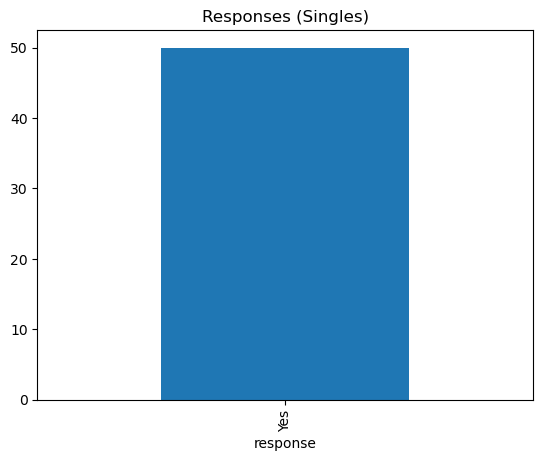

In [27]:
extract_and_analyze_results(singles, "Singles")


################# Analyzing results for Families... #################
Extraction raw result message: {'content': '{"response":"No","justification":"While I appreciate the idea of a quiet and luxurious vacation, my current priorities revolve around family time and child-friendly activities. My ideal vacation involves spending quality time with my children, exploring nature, and engaging in family-oriented experiences rather than adult-only getaways. Additionally, I often look for budget-friendly options that accommodate my family\'s needs, which may not align with luxury services."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response":"No","justification":"While I appreciate the idea of a quiet and luxurious vacation, my current situation as a parent means that I prioritize family-friendly destinations. I look for vacations that allow me to spend quality time with my children, explore new places together, and engage in activi

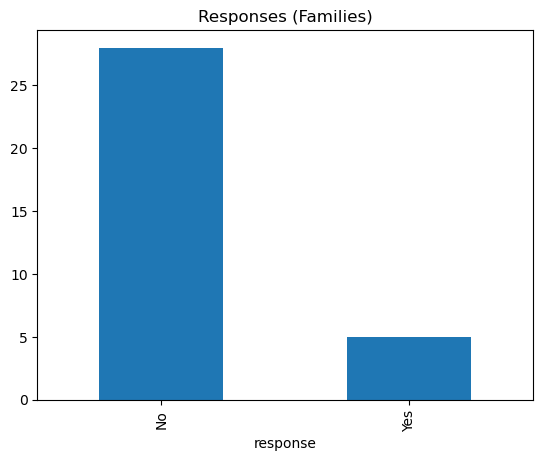

In [28]:
extract_and_analyze_results(families, "Families")

################# Analyzing results for Couples... #################
Extraction raw result message: {'content': '{"response": "Yes", "justification": "I appreciate the focus on luxury and relaxation, which aligns with my current desire for a calm getaway. Given my busy job in marketing, I often look for vacations that allow me to unwind and recharge. I prefer avoiding crowded places and fake reviews, so a service that curates quality experiences sounds appealing."}', 'refusal': None, 'role': 'assistant', 'annotations': []}
Extraction raw result message: {'content': '{"response":"Yes","justification":"I appreciate the focus on luxury and relaxation, which aligns with my interests in exploring new destinations and enjoying quiet getaways. Given my current job in healthcare, I often find myself needing a break from the stresses of work, and a calm beachfront vacation sounds ideal. I value authentic experiences and would prefer to avoid the hassle of sifting through unreliable reviews."}',

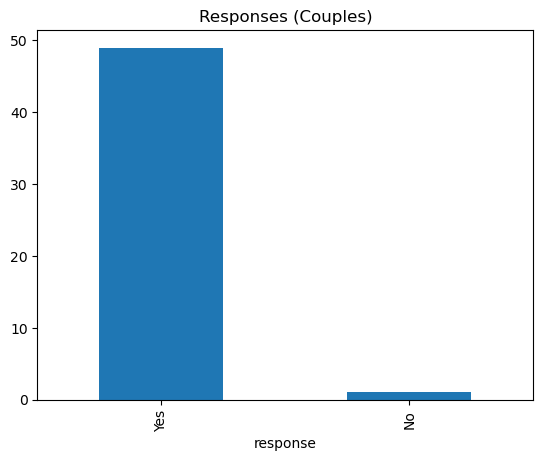

In [29]:
extract_and_analyze_results(couple, "Couples")

In [31]:
control.end()